In [ ]:
import matplotlib.pyplot as plt ### Data visualization
import numpy as np ### Manage arrays
import pandas as pd ### DataFrames and manage our dataset

In [ ]:
from sklearn.datasets import fetch_california_housing

In [5]:
!unzip houses_s191894 -d data

Archive:  houses_s191894.zip
  inflating: data/system_diagnostics_house_prediction_v2.ipynb  
  inflating: data/__MACOSX/._system_diagnostics_house_prediction_v2.ipynb  
  inflating: data/dataset_processed.pickle  
  inflating: data/__MACOSX/._dataset_processed.pickle  
  inflating: data/model_price_house.pickle  
  inflating: data/__MACOSX/._model_price_house.pickle  
  inflating: data/extra_features.pickle  
  inflating: data/__MACOSX/._extra_features.pickle  


### ***Fetching Dataset***

In [6]:
dataset = fetch_california_housing()

In [7]:
### In our dataset we have 20640 rows, each one of them represents a house in the state of California

print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [8]:
df = pd.DataFrame(dataset.data, columns = dataset.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
### There is not target column in our DataFrame. Let's add it from the original dataset
### Target is measured in units, each unit corresponds to 100.000$

df['Target'] = dataset.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### ***Exploratory Data Analysis***

In [10]:
### Now we are going to analyze our data and see what features are important and which not (correlation)
### To visualize the data better, I usually use a third party software called SweetViz, which works pretty good in these cases

import sys

!{sys.executable} -m pip install sweetviz

     |████████████████████████████████| 15.1 MB 7.4 MB/s 


In [11]:
import sweetviz as sv

analysis = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)


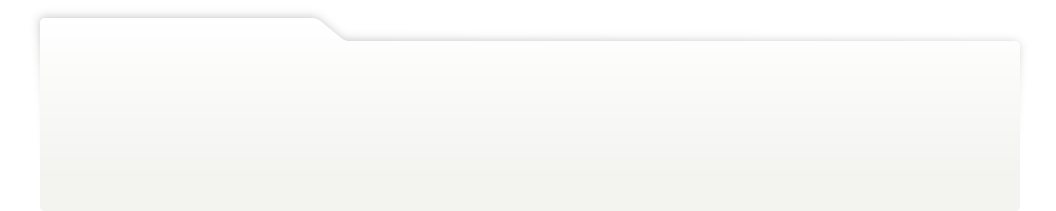
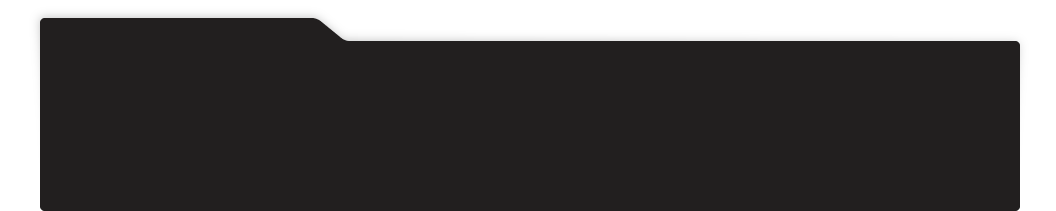
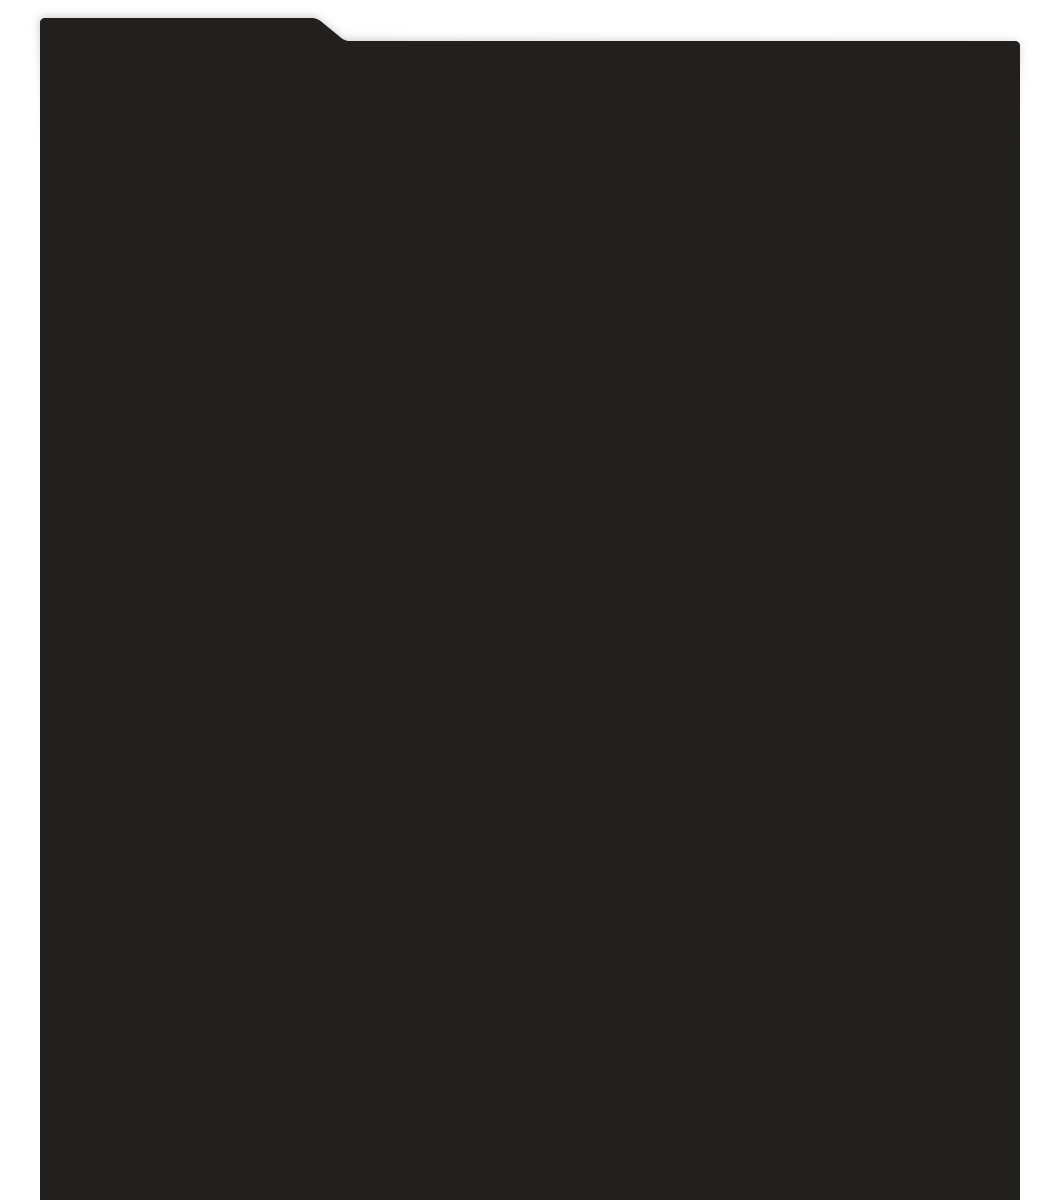
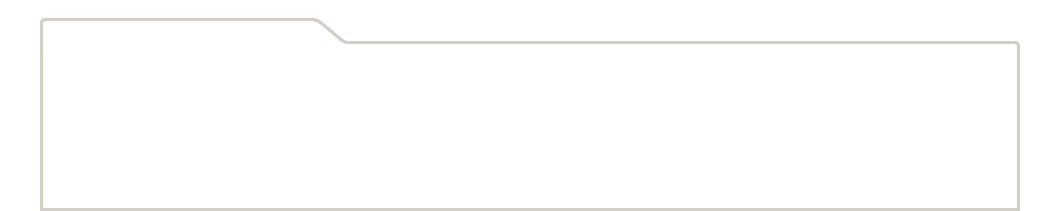
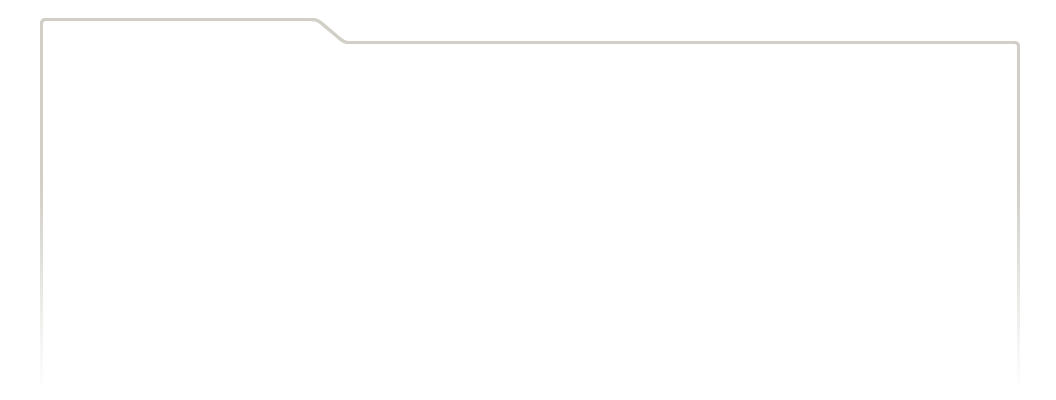
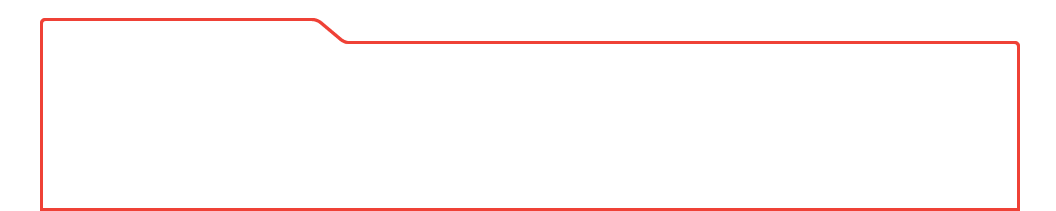
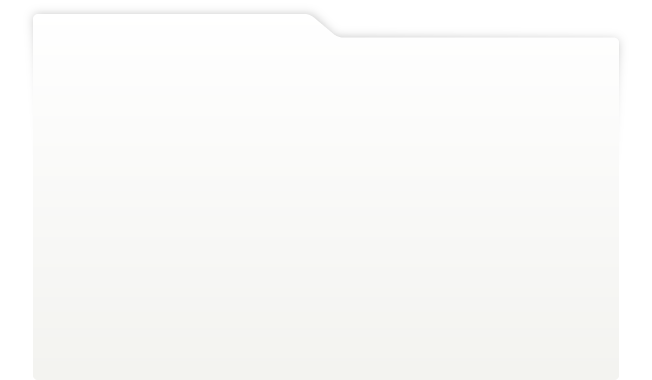
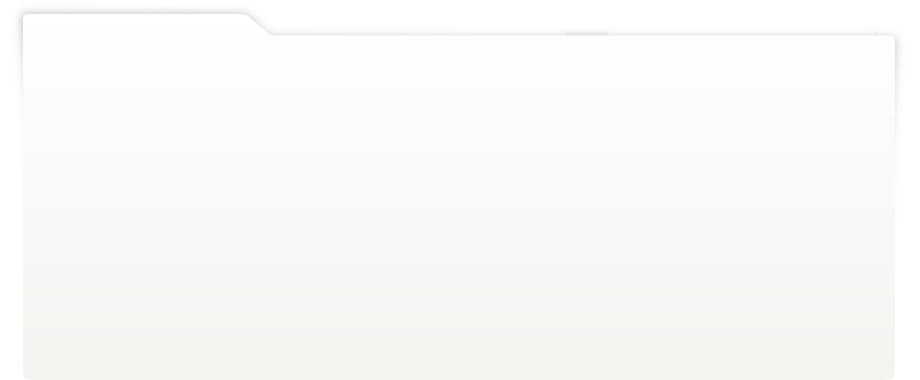
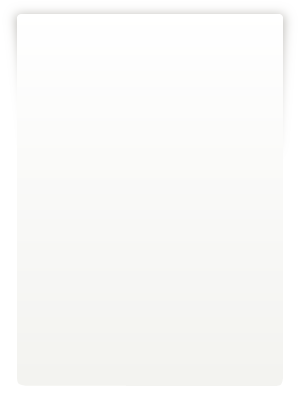
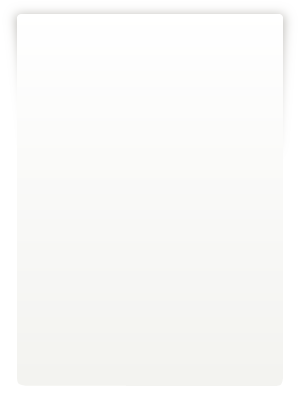
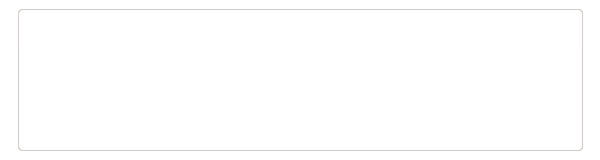
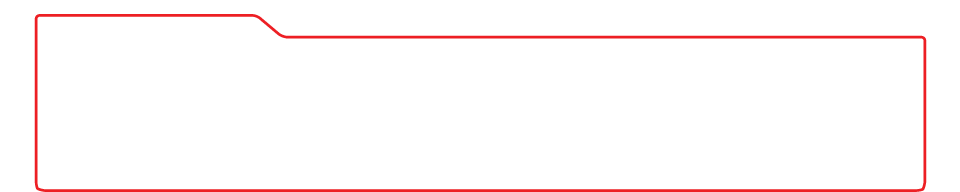
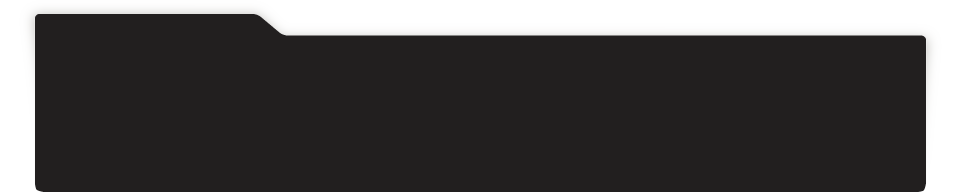
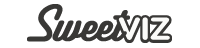
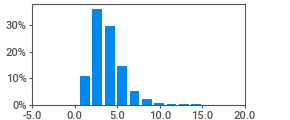
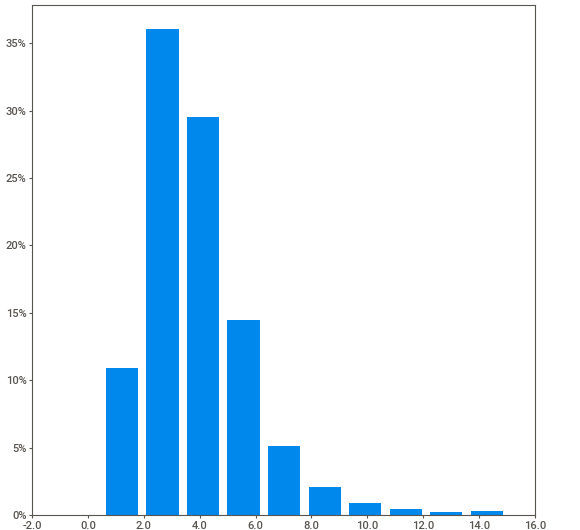
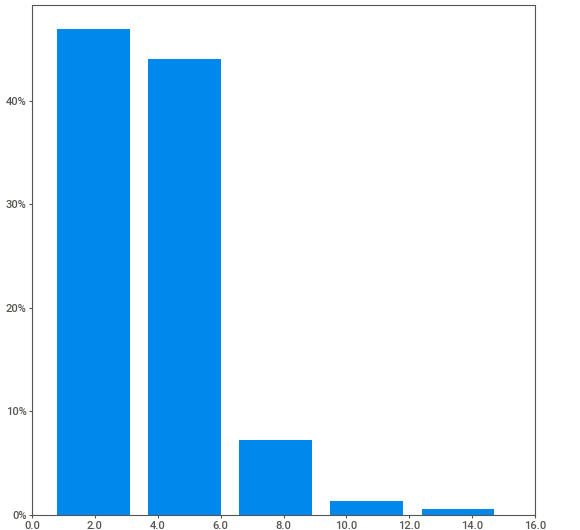
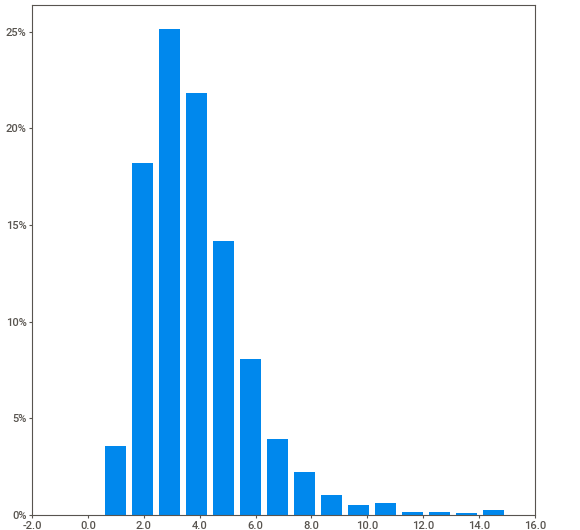
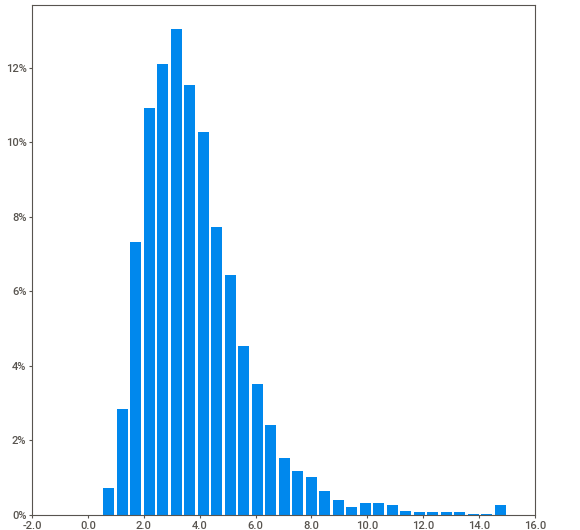
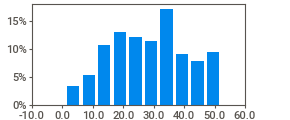
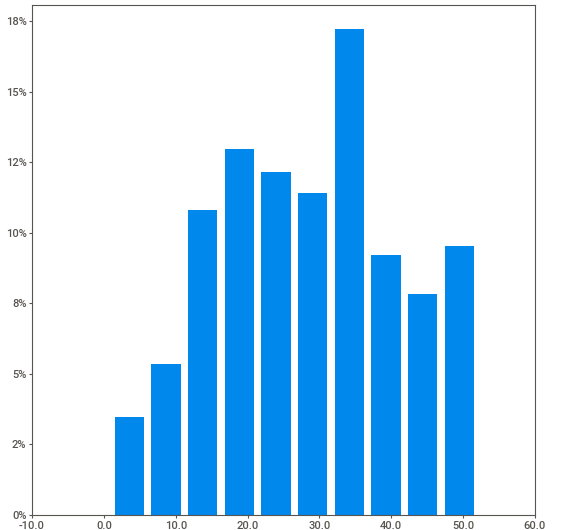
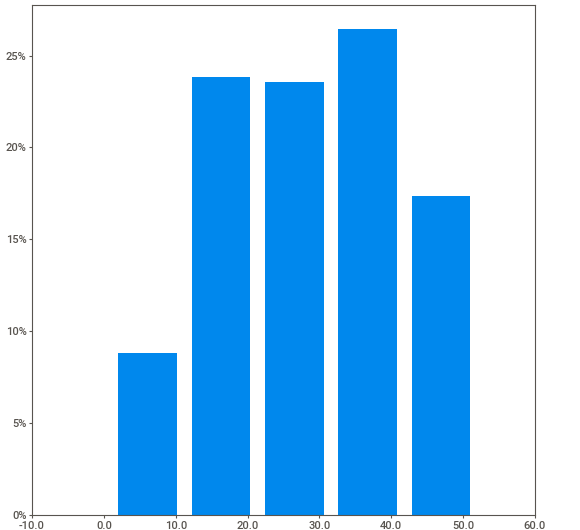
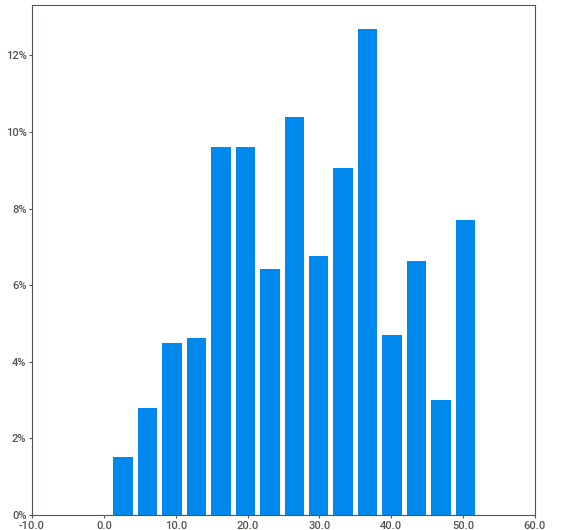
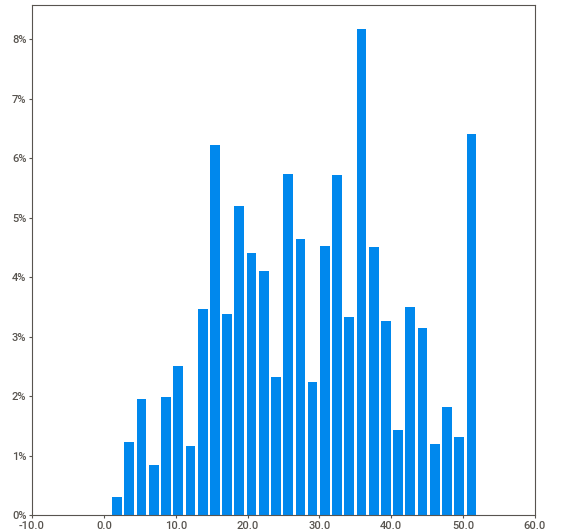
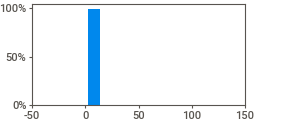
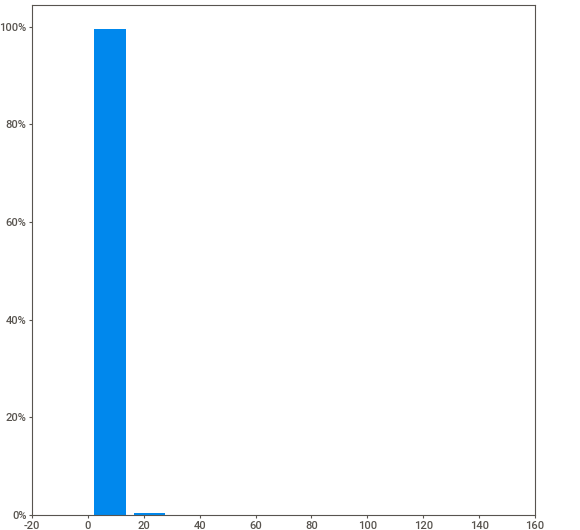
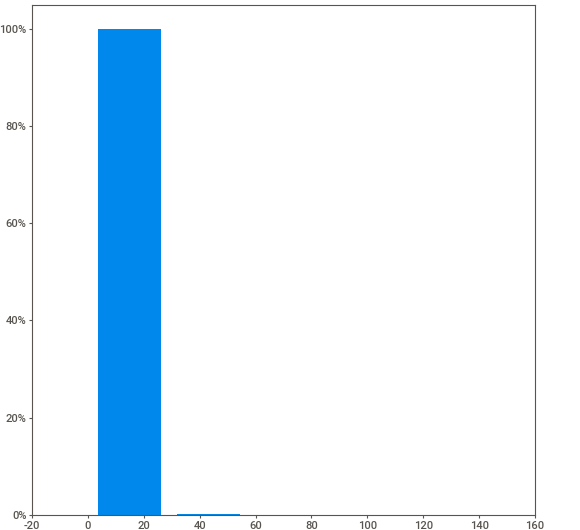
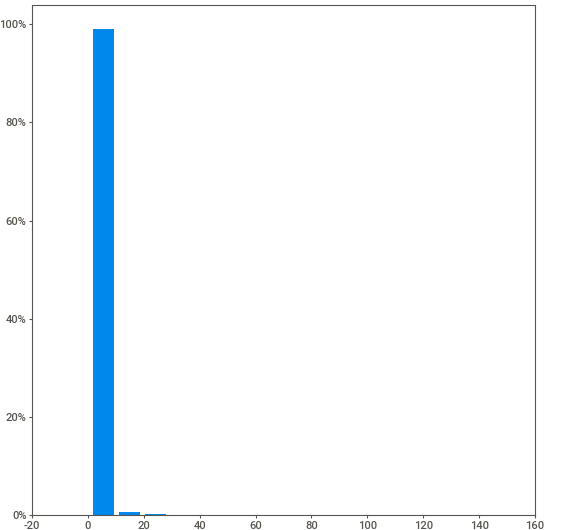
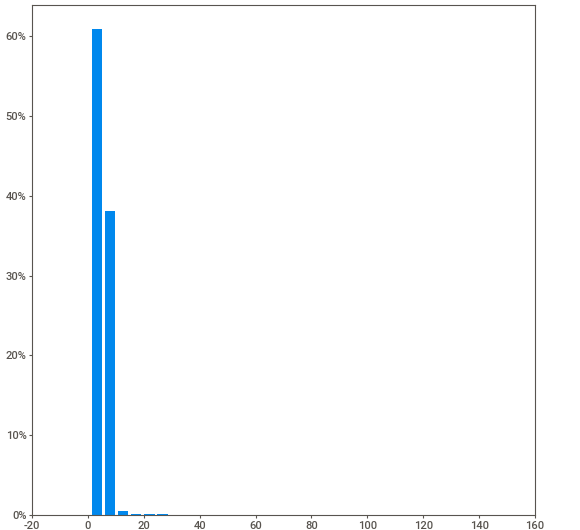
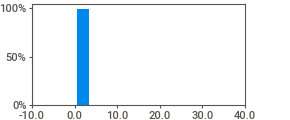
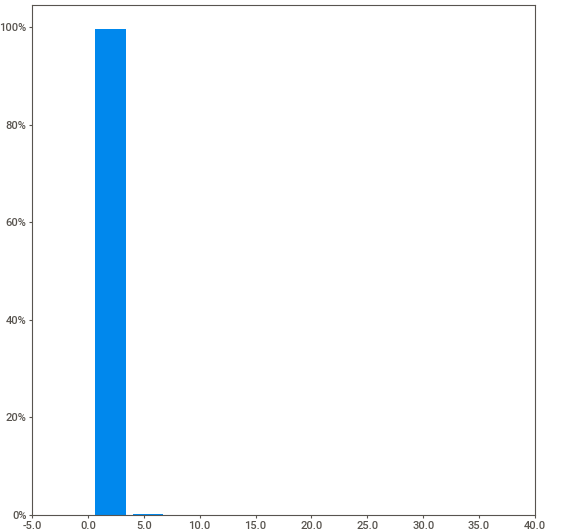
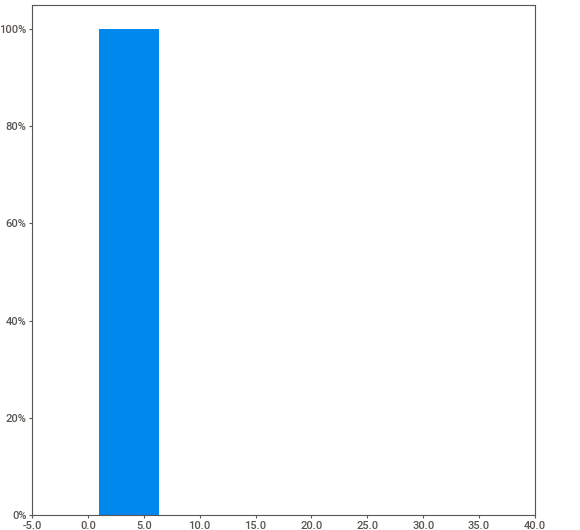
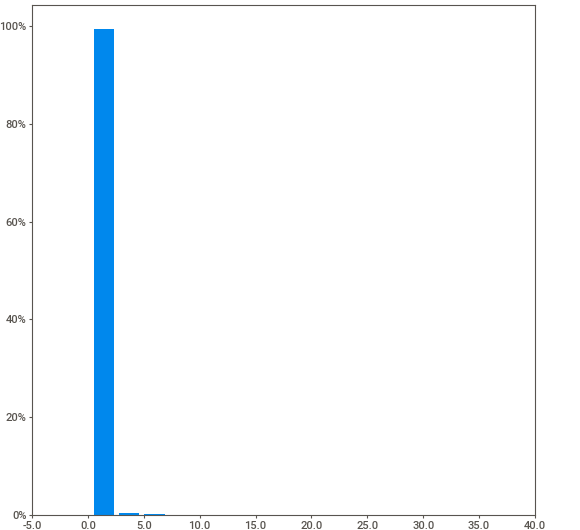
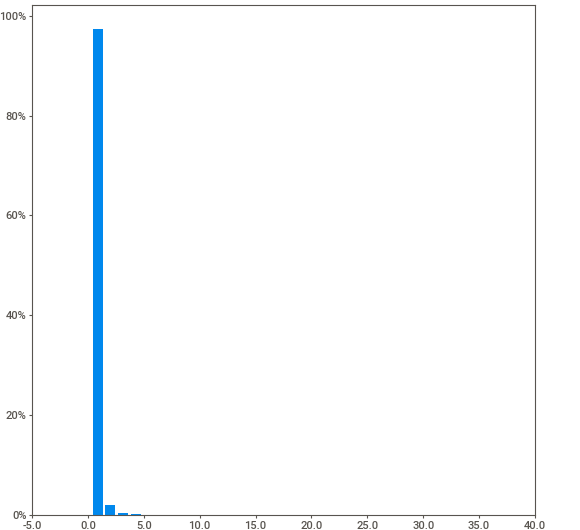
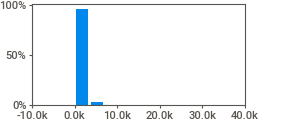
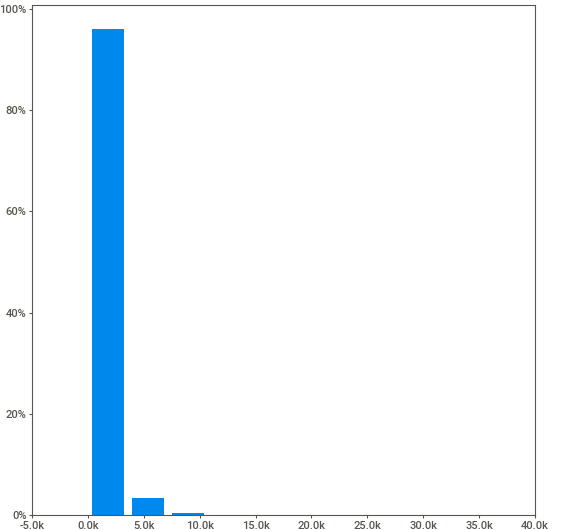
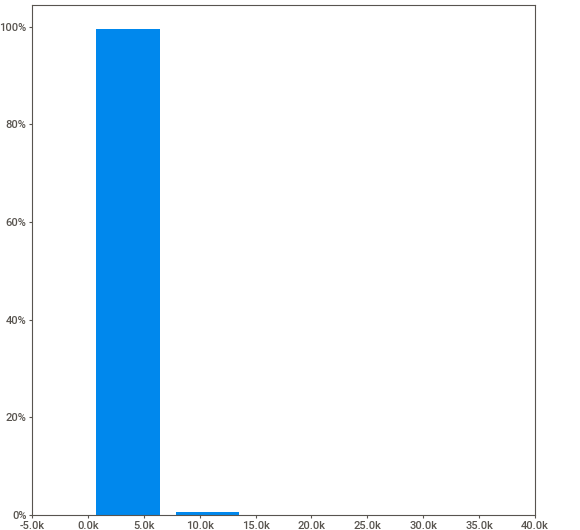
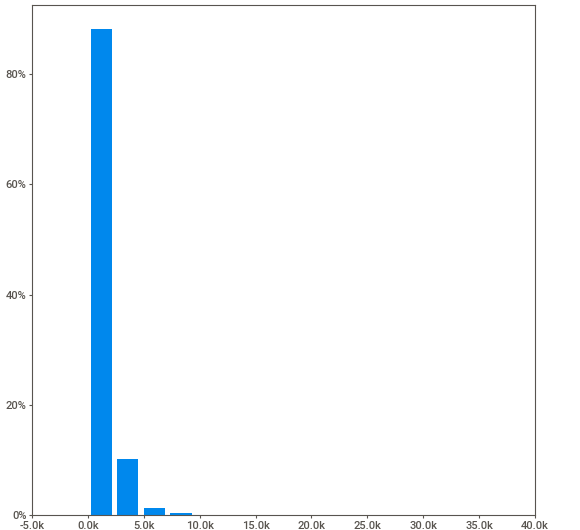
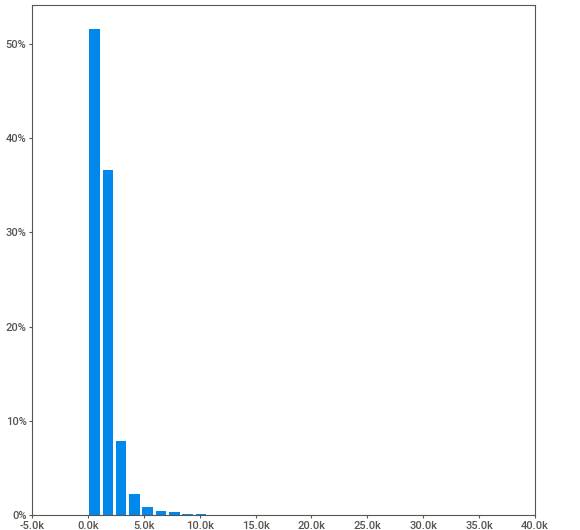
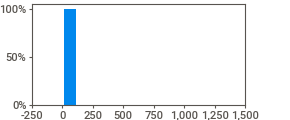
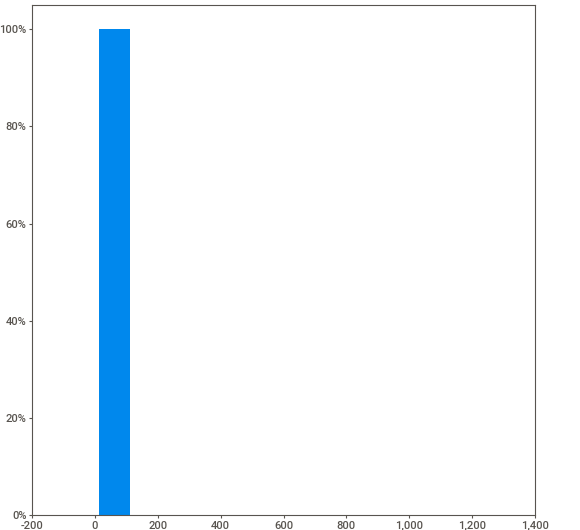
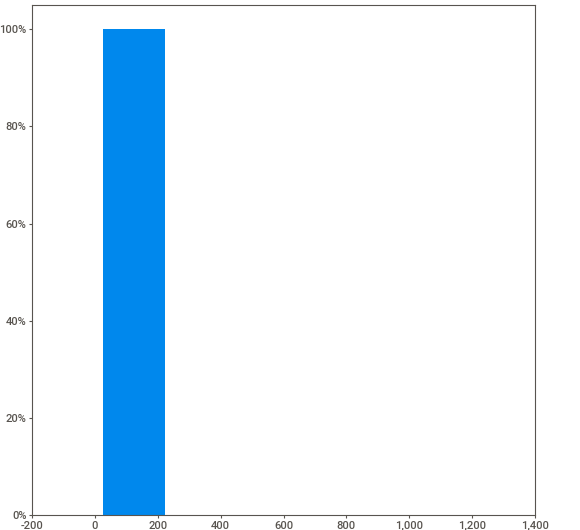
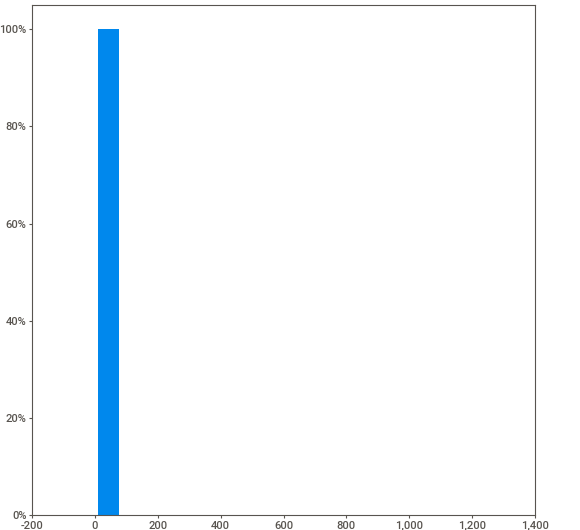
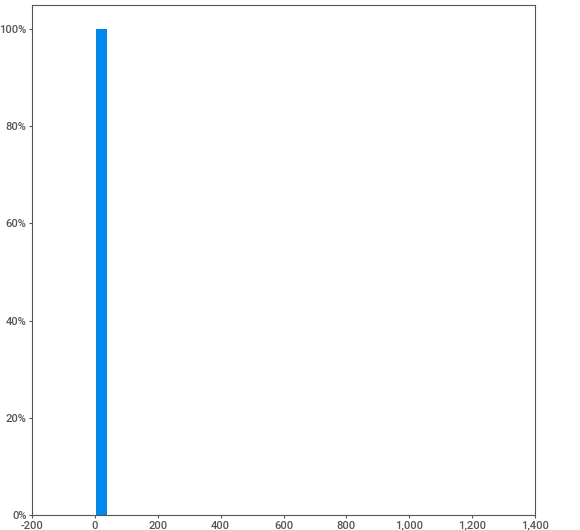
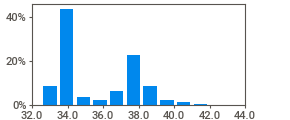
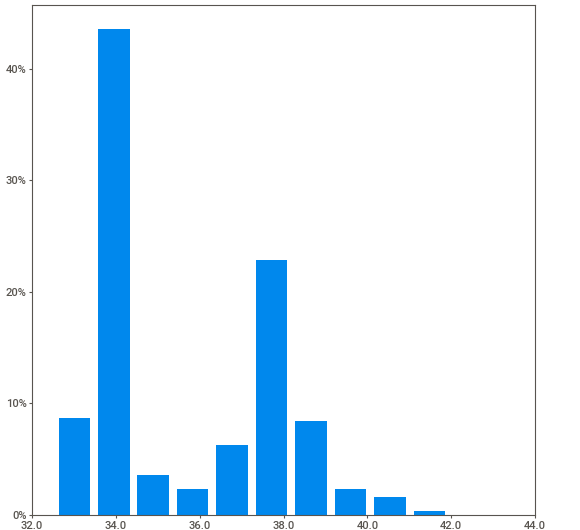
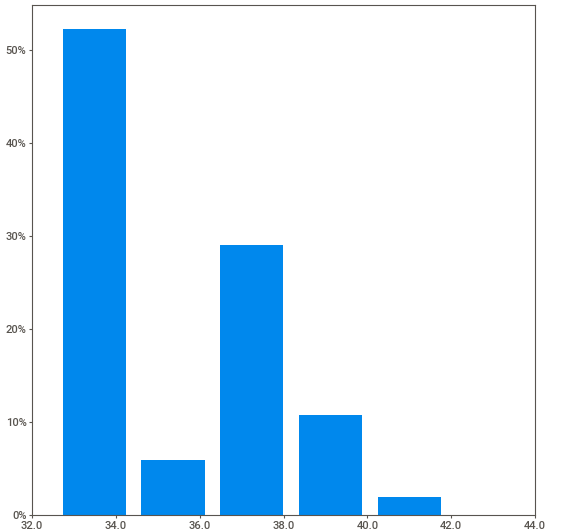
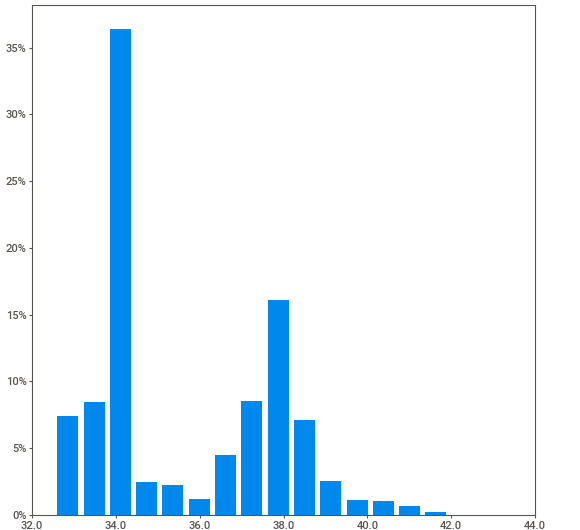
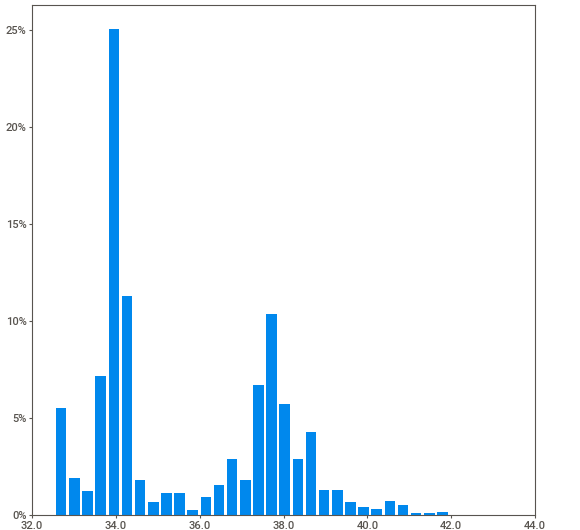
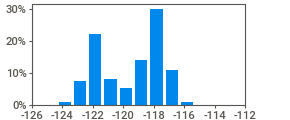
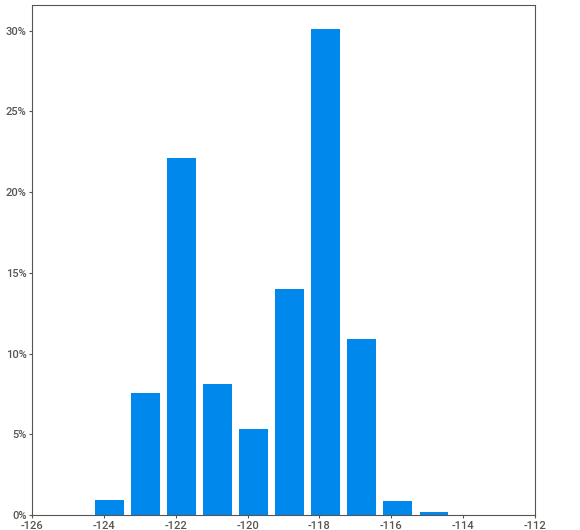
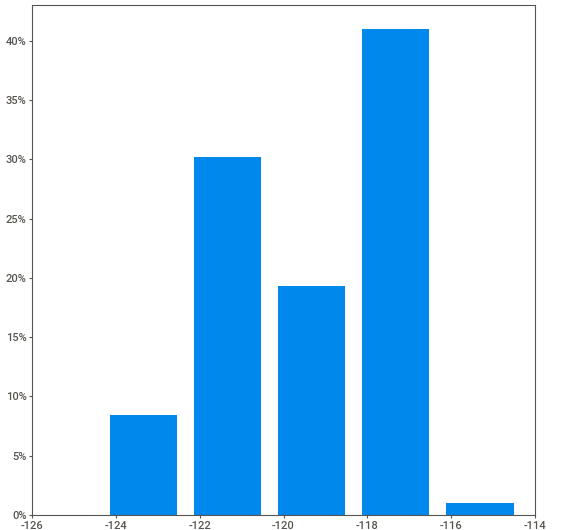
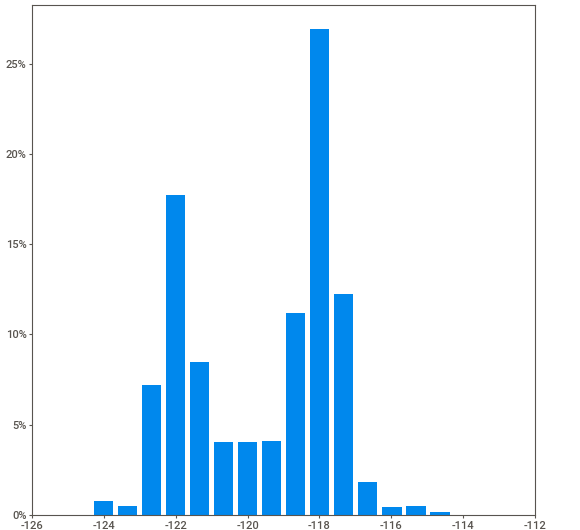
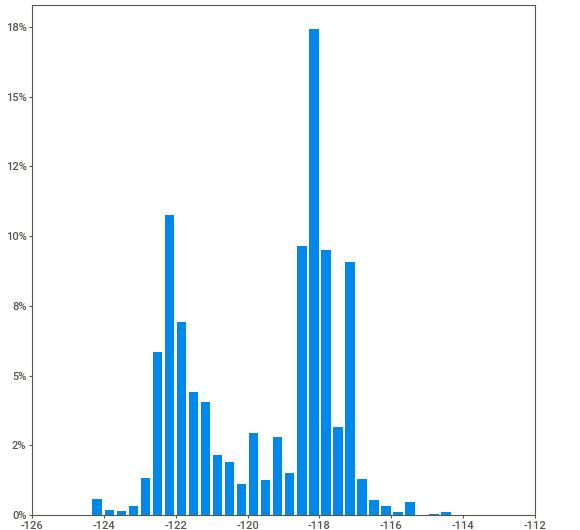
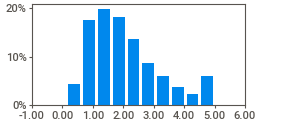
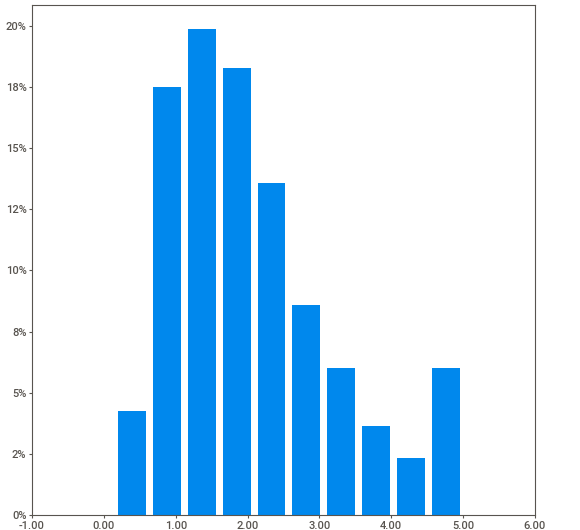
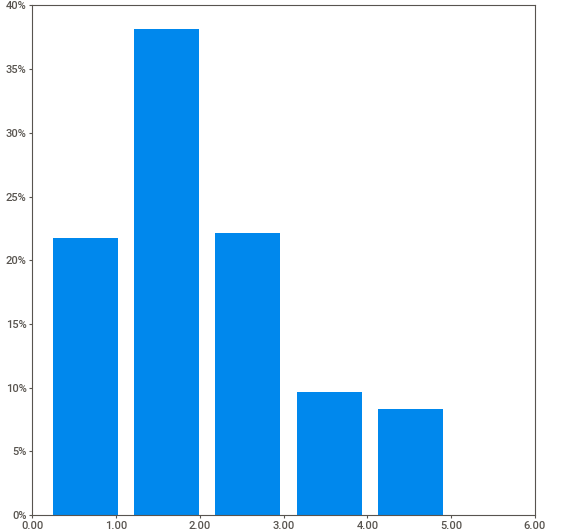
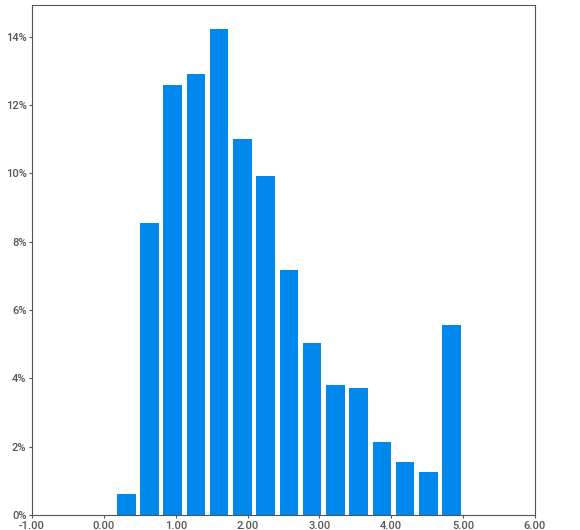
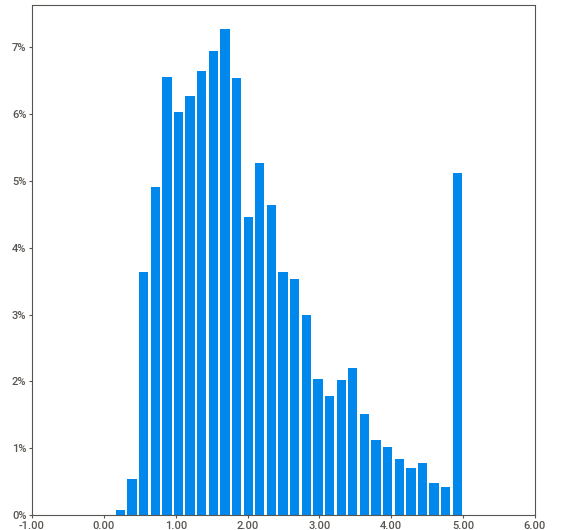
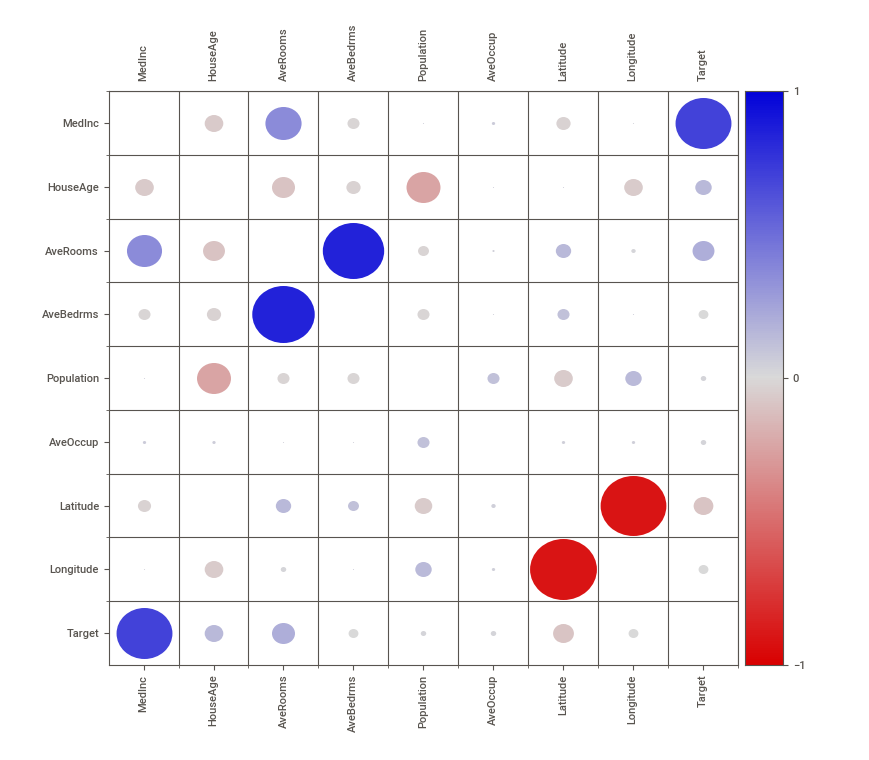
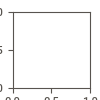

In [12]:
### We can also save it as a HTML file and look at the information in our browser.
### For the sake of the project I'll just print it in the notebook

analysis.show_notebook()

In [13]:
!{sys.executable} -m pip install plotly

In [14]:
### By looking at the data above, we can see that the most correlated values are the target and the average income.
### It makes sense, a family that has more income, will tend to buy a more expensive house. Let's print now a map of California
### with the different locations of houses and prices.

import plotly.express as px

mapbox_access_token = 'pk.eyJ1IjoiaWx5YWFuIiwiYSI6ImNreXU4eTlsZDA4Z3Ayd294YzRrZDRjd3IifQ.eboKizLqQhRGk_SpfeuSXA'
px.set_mapbox_access_token(mapbox_access_token)

### Print the mao

fig = px.scatter_mapbox(df, mapbox_style = 'streets', lat = 'Latitude', lon = 'Longitude', zoom = 5, color = 'Target', color_continuous_scale = px.colors.diverging.RdYlBu_r)

fig.show()

In [15]:
### Now it's even more clear where are the more expensive houses. Based on this data we can conclude some things. First of all,
### location is very important in regards to the price of the house, but there is a problem. Previously we visualized the data
### with SweetViz and we found out that the Latitude and Longitude were not correlated too much with the price of the house, but here 
### we can see that that's not true. Houses in bigger cities near the ocean are more valuable. How can we solve this?
### The problem actually is that the Latitude and Longitude by themselves are not too meaningfull to our model, so what we are going to do
### is extract the county, and also the road if possible, then drop the latitude and longitude and try again to see if the county and road
### are correlated to the price or not.

### Documentation to the geocoder used -> https://geopy.readthedocs.io/en/stable/#nominatim
### Using this snipper that I found in StackOverFlow we can retrieve all the data regarding a coordinate
### Street, Postal Code, City, Country, County, State...

from geopy.geocoders import Nominatim

locator = Nominatim(user_agent = 'californiaHousePrediction')

In [16]:
locator.reverse('{0}, {1}'.format('34.02', '-118.88'))[0]

'Malibu, Los Angeles County, California, 90265-4797, United States'

In [17]:
locator.reverse('{0}, {1}'.format('34.02', '-118.88')).raw['address']

### With the attribute raw we can get a dictionary instead of a string

{'country': 'United States',
 'country_code': 'us',
 'county': 'Los Angeles County',
 'postcode': '90265-4797',
 'state': 'California',
 'town': 'Malibu'}

In [18]:
def getLocationData(coords):
    data = locator.reverse('{0}, {1}'.format(coords[0], coords[1])).raw['address']
    if data.get('county') is None:
        data['county'] = None
    if data.get('road') is None:
        data['road'] = None
    extra_features['County'].append(data['county'])
    extra_features['Road'].append(data['road'])

In [19]:
import pickle as pk

# extra_features = {'County': [], 'Road': []}

# for i, coord in enumerate(df.iloc[:,6:-1].values):
#     if i % 100 == 0:
#         print('Iteration {0}'.format(i))
#     getLocationData(coord)
#     pk.dump(extra_features, open('extra_features.pickle', 'wb'))

In [22]:
extra_features = pk.load(open('data/extra_features.pickle', 'rb'))

In [23]:
info_extra_features = pd.DataFrame(extra_features)

In [24]:
print(info_extra_features.info())

### There are some null values that we have to work with, otherwise we will need to drop them
### A good approach can be predict those values based on other factors such as price and latitude and longitude

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   County  20065 non-null  object
 1   Road    19541 non-null  object
dtypes: object(2)
memory usage: 322.6+ KB
None


In [25]:
for key in extra_features.keys():
    df[key] = extra_features[key]

df.drop(labels = ['Latitude', 'Longitude'], axis = 1, inplace = True)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Target,County,Road
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526,Alameda County,Upper Side Hill entrance
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585,Alameda County,Charing Cross Road
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521,Alameda County,Grove Shafter Freeway
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413,Alameda County,Florio Street
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422,Alameda County,Florio Street


                                             |          | [  0%]   00:00 -> (? left)


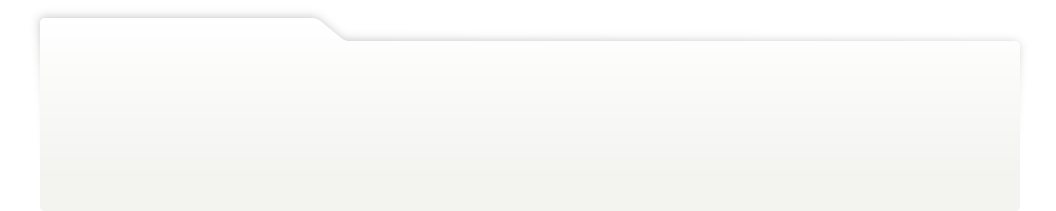
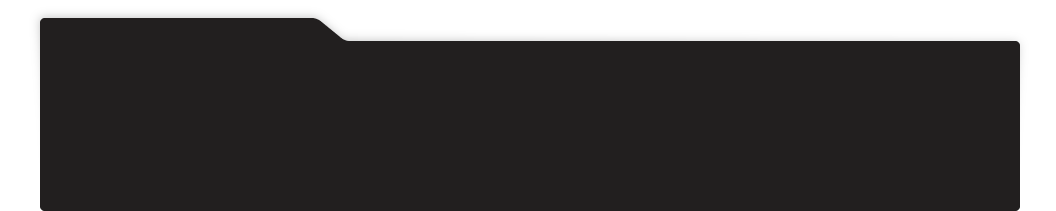
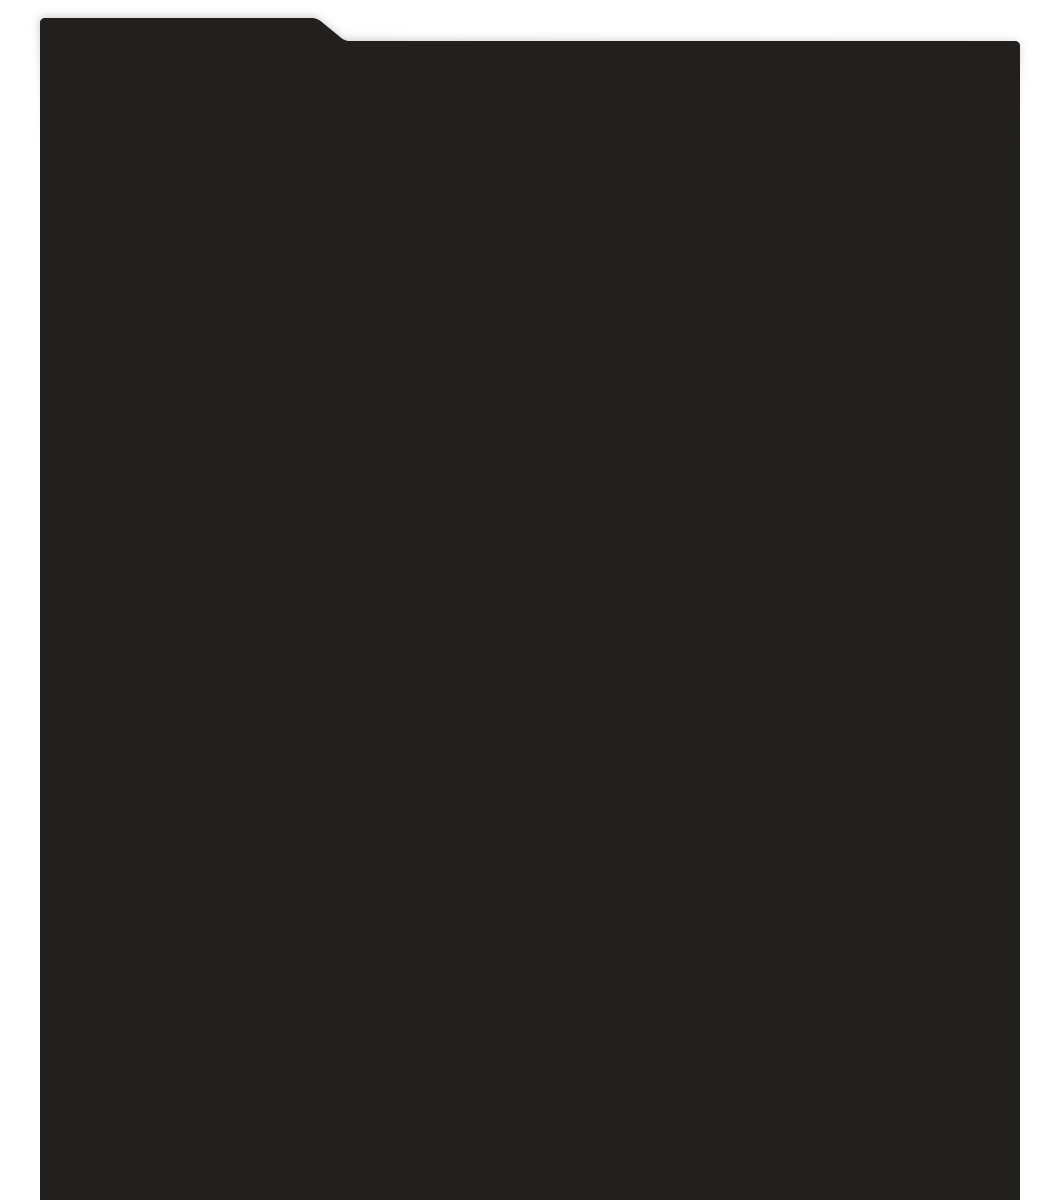
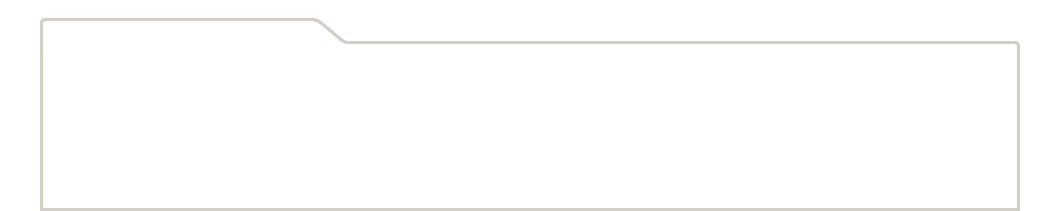
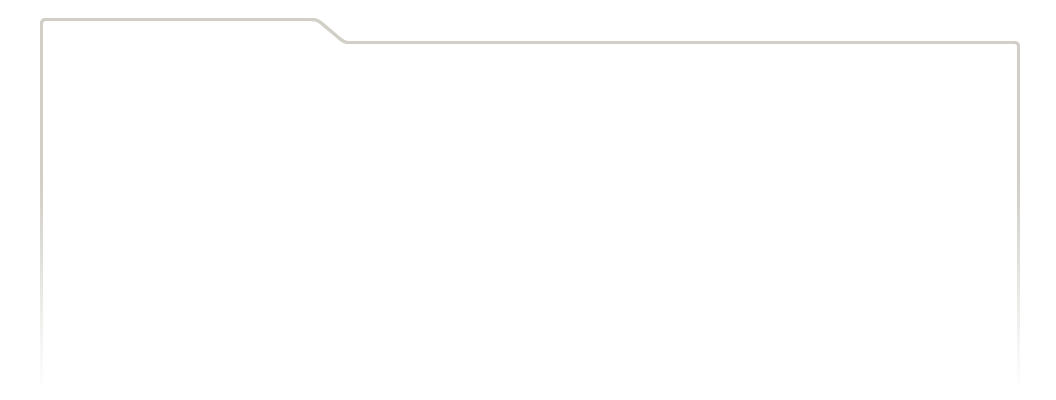
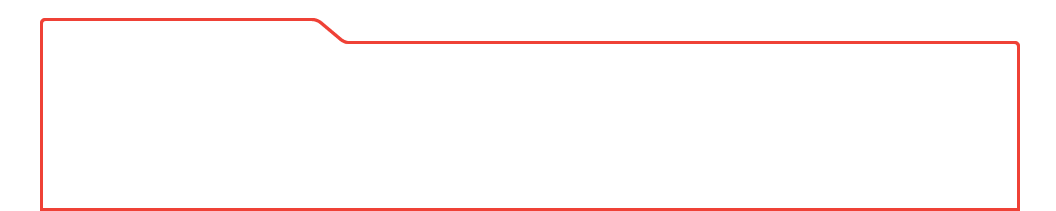
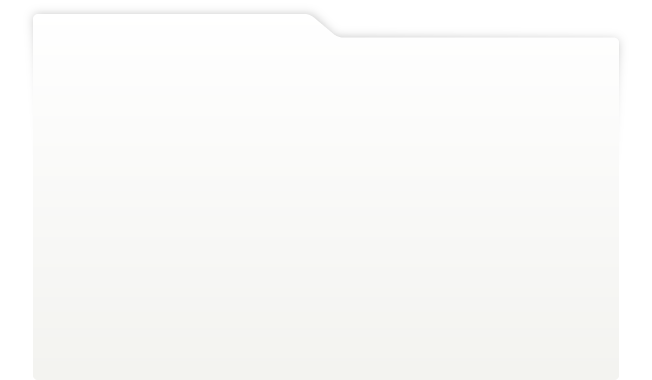
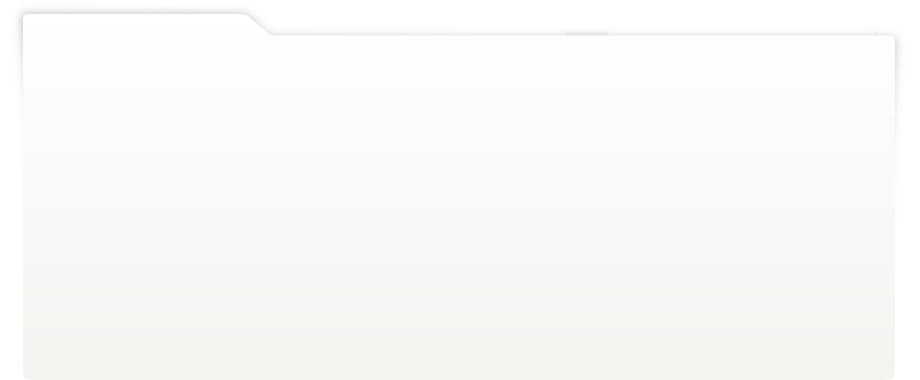
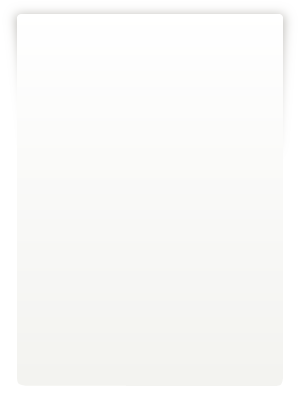
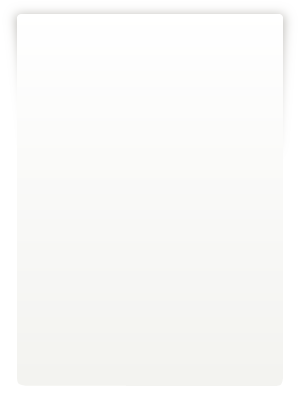
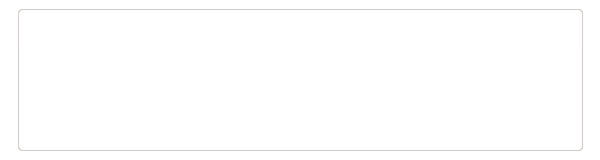
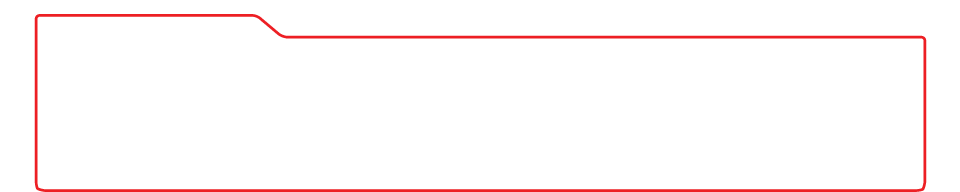
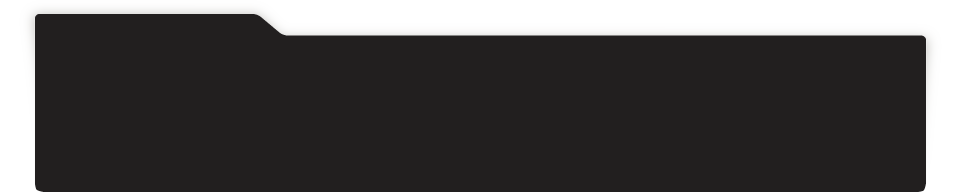
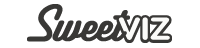
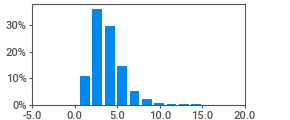
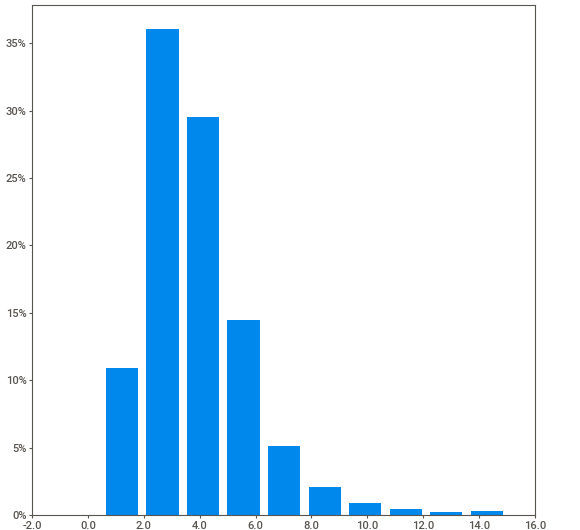
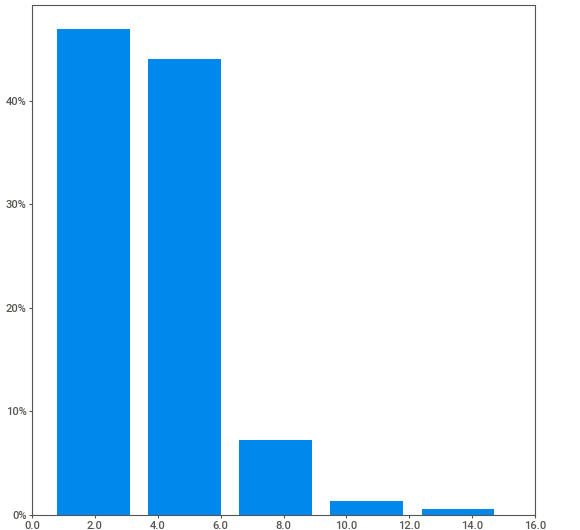
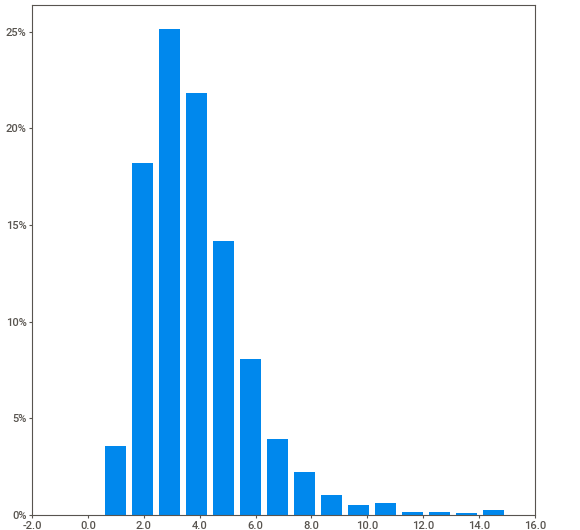
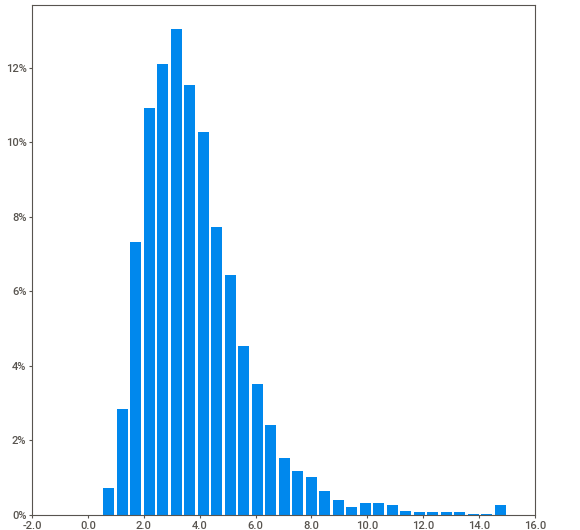
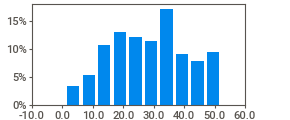
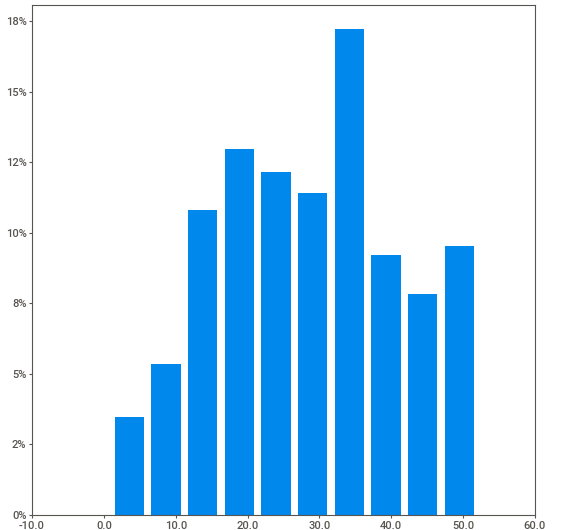
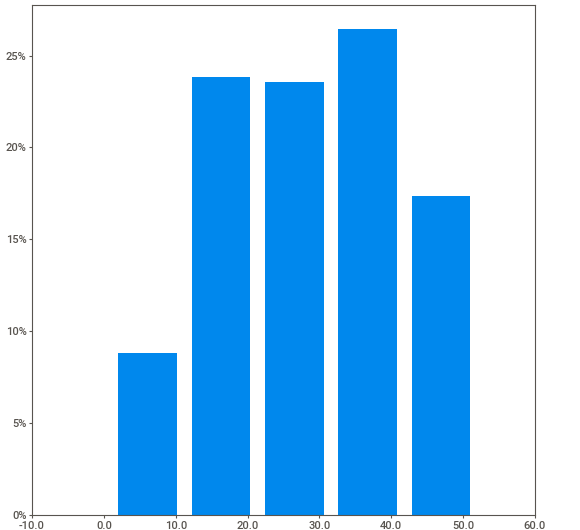
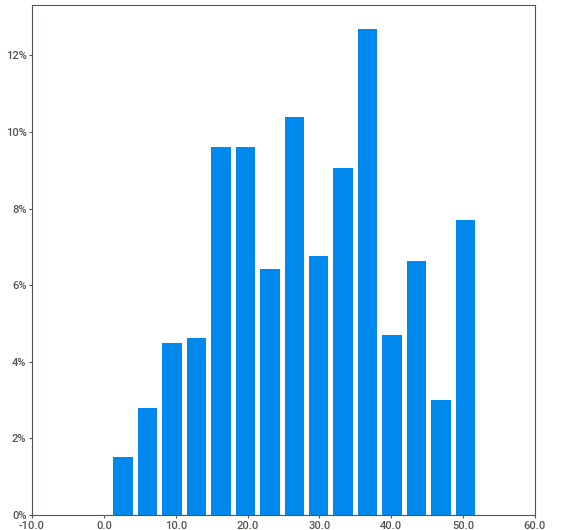
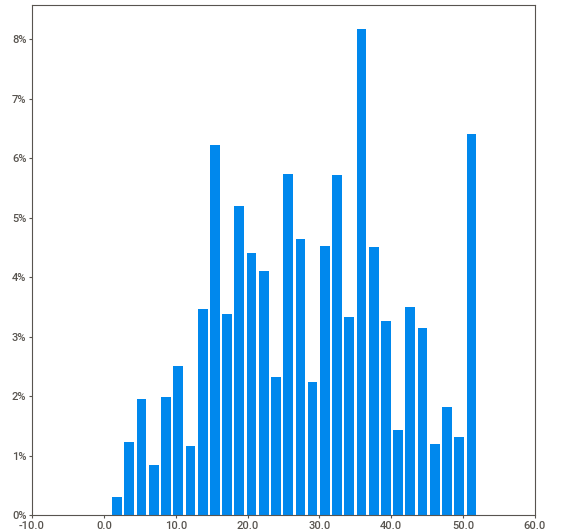
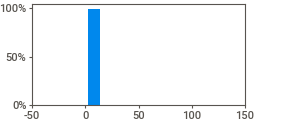
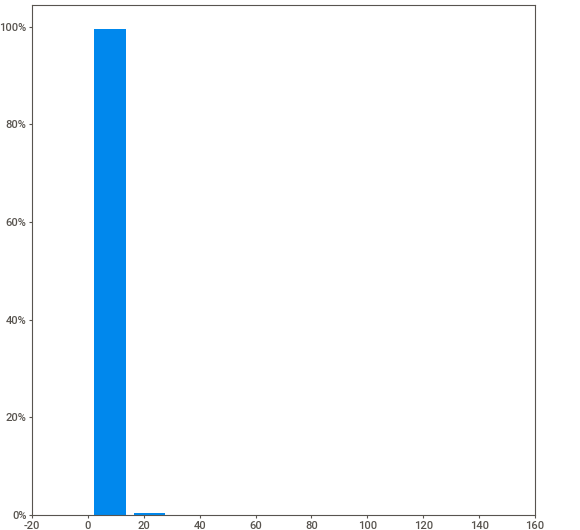
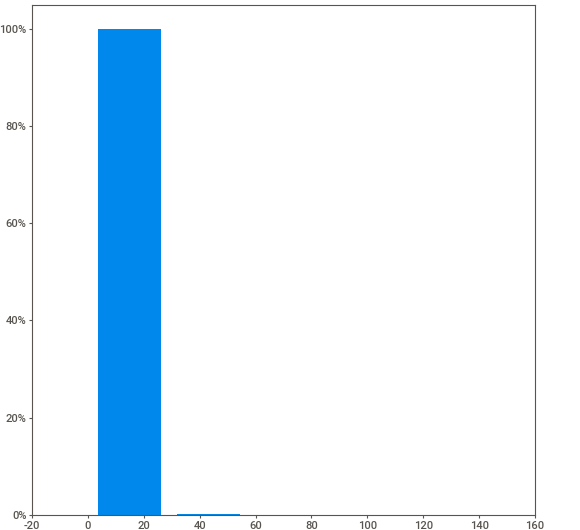
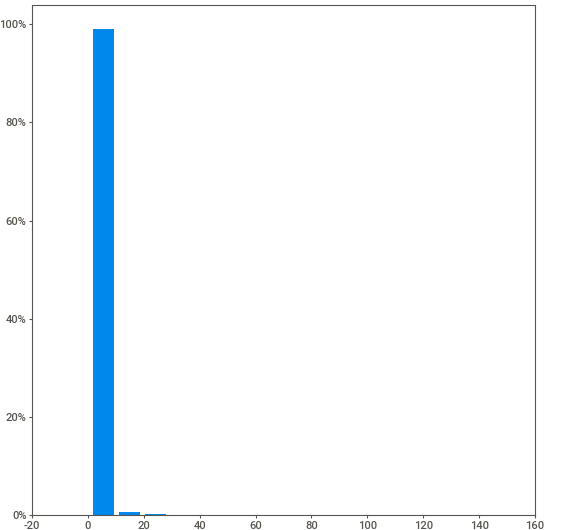
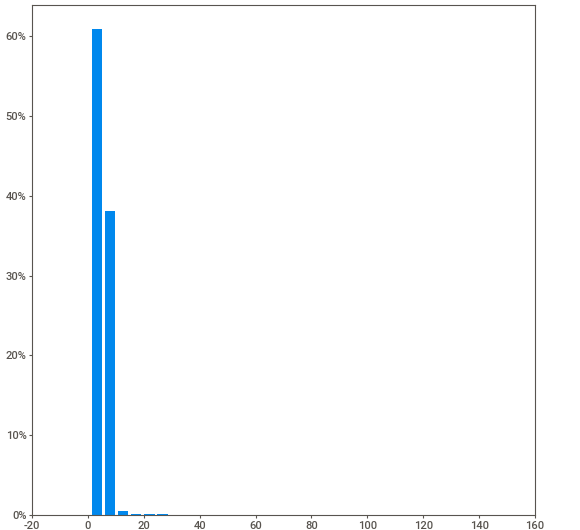
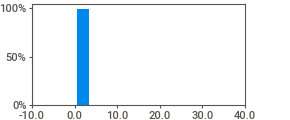
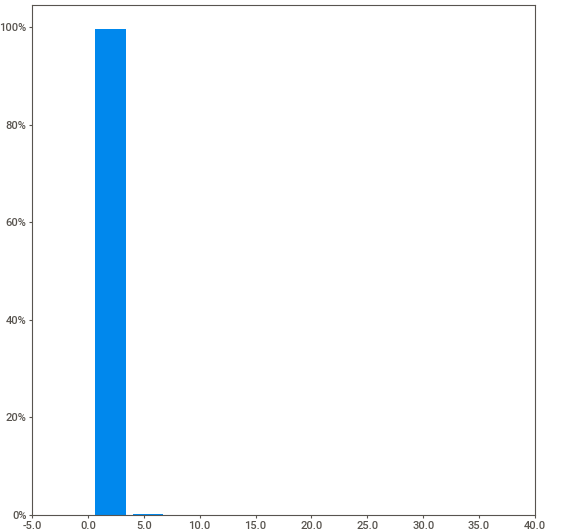
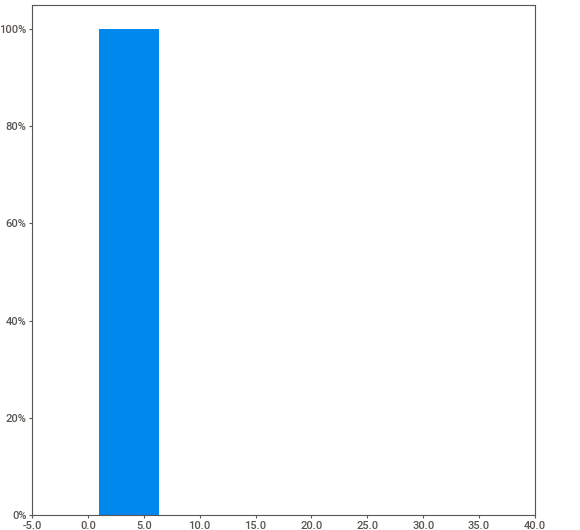
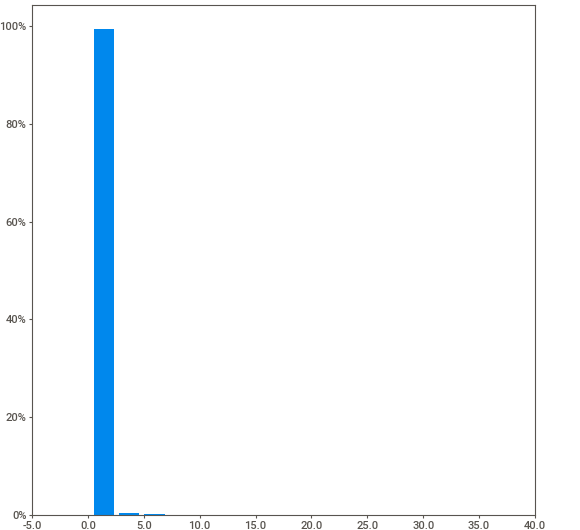
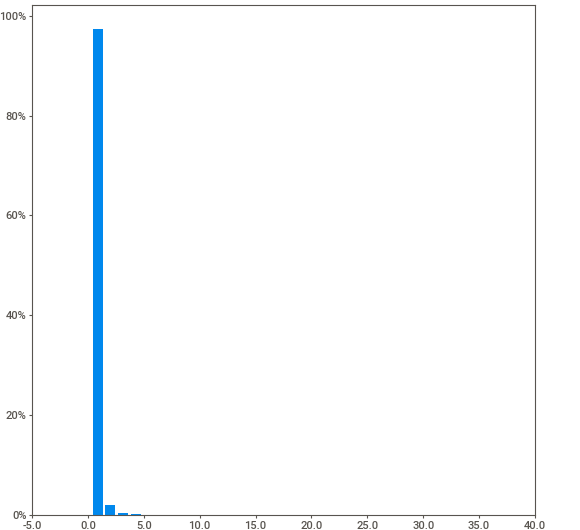
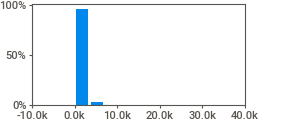
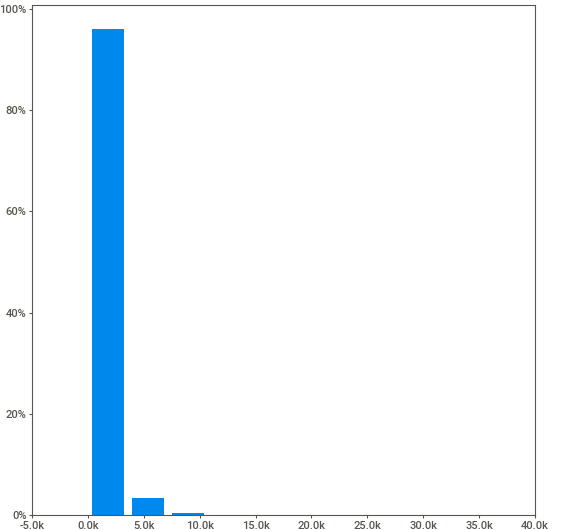
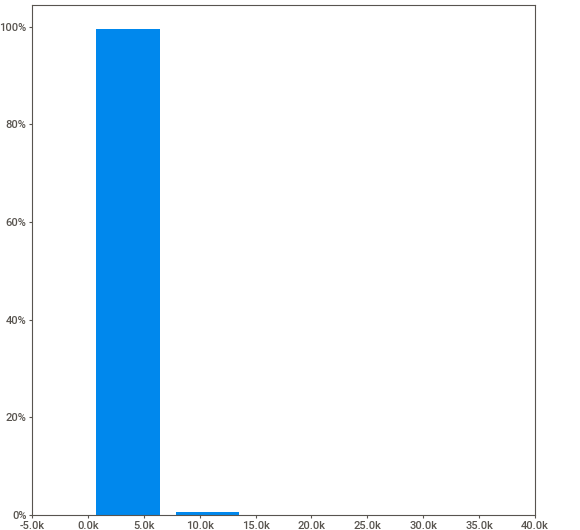
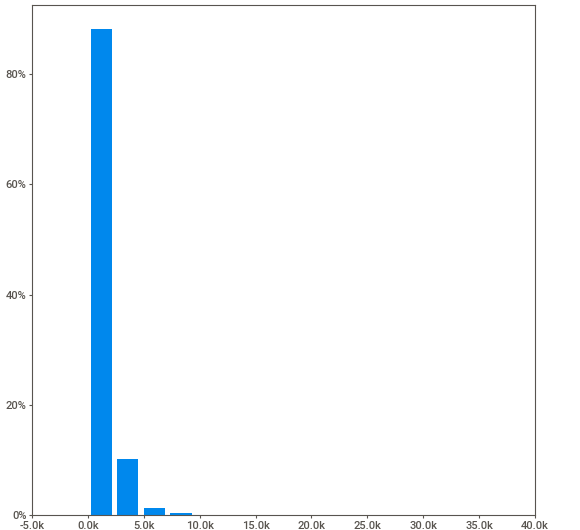
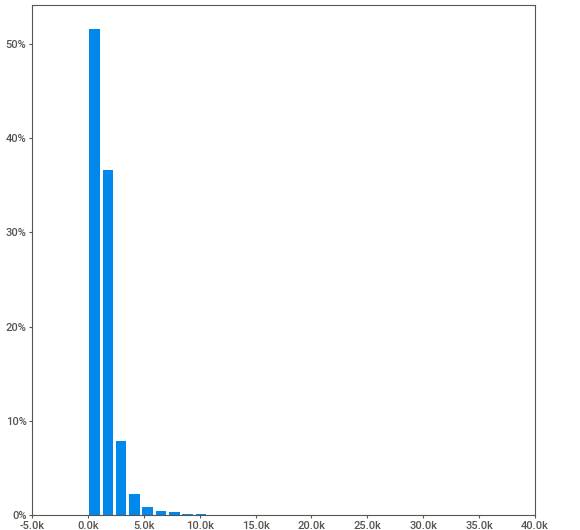
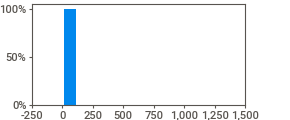
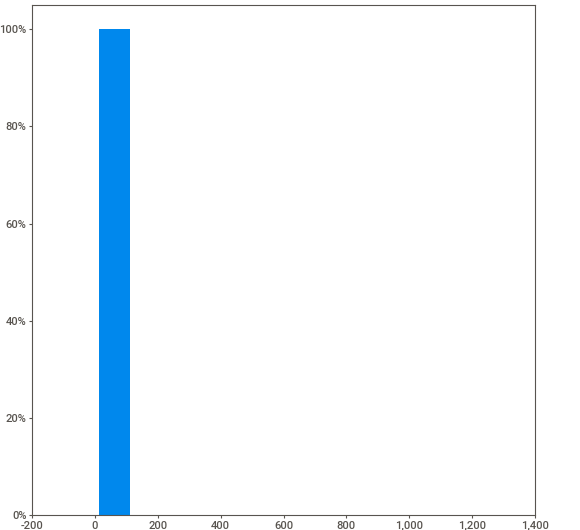
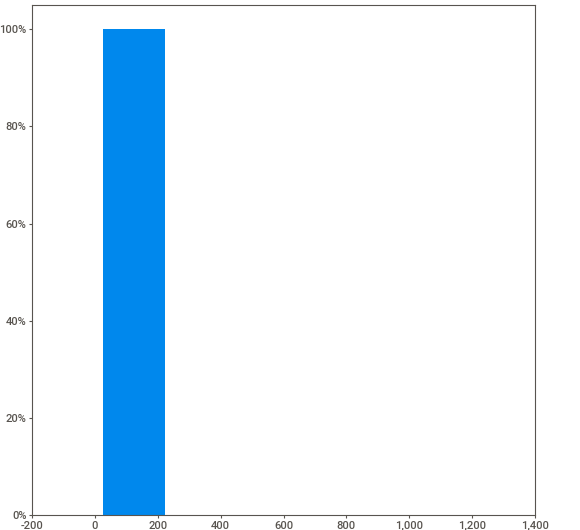
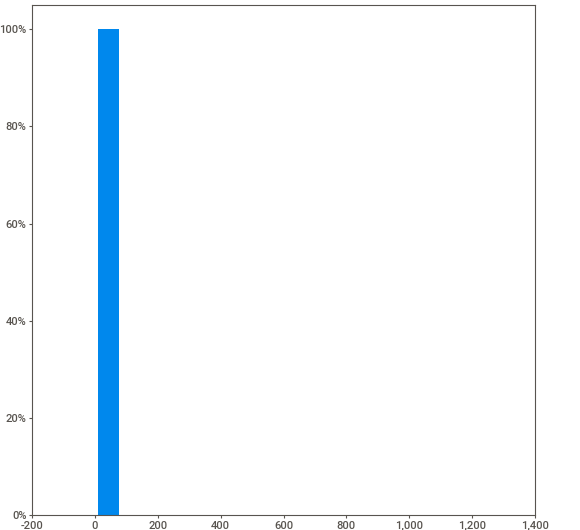
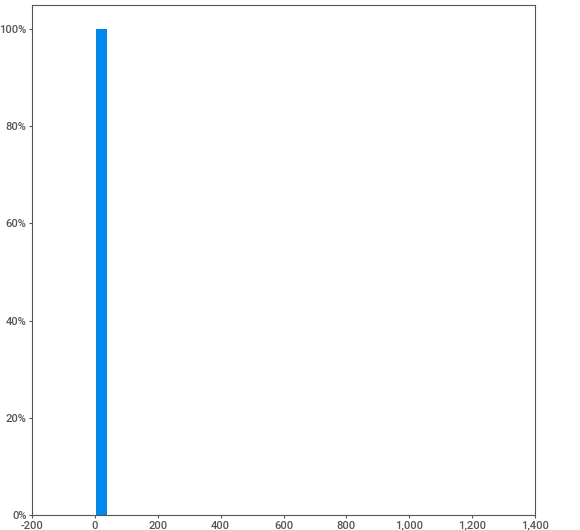
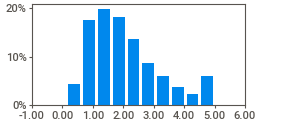
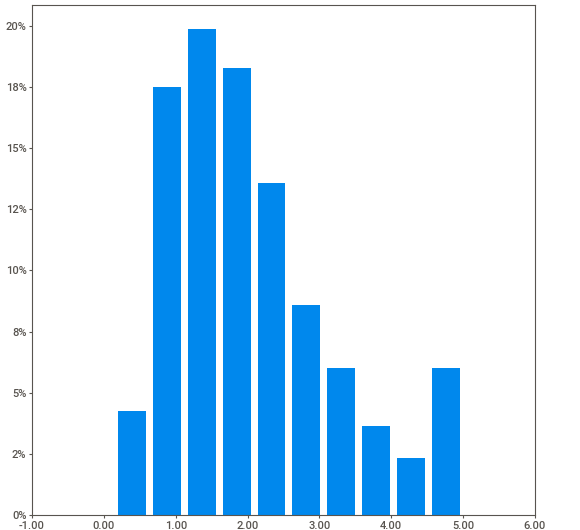
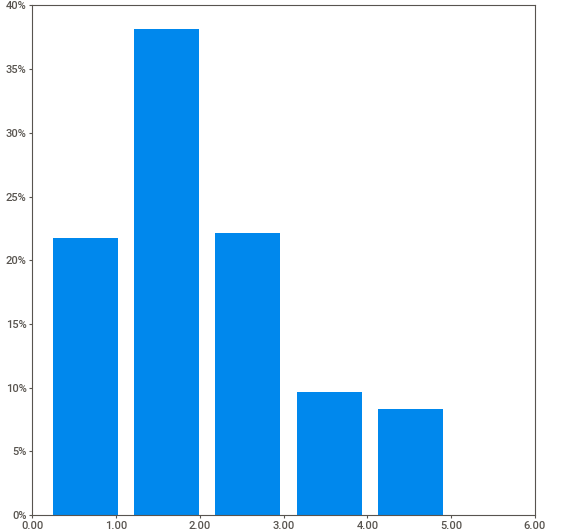
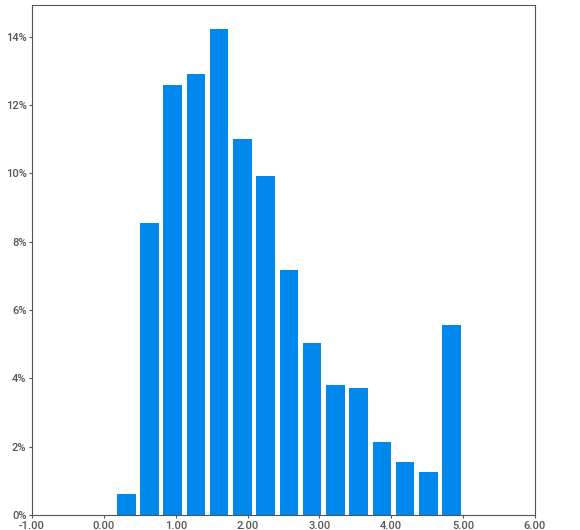
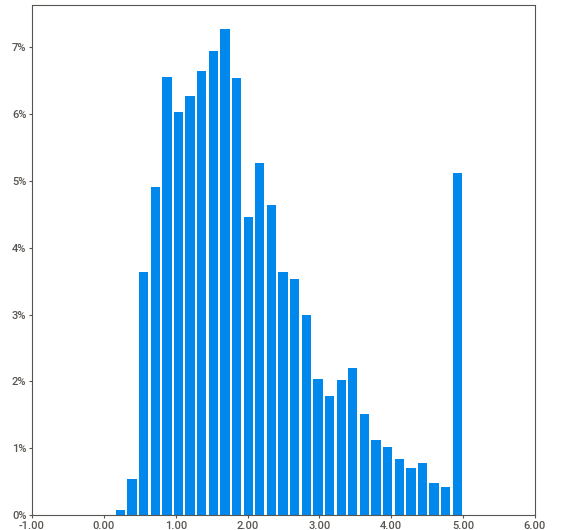
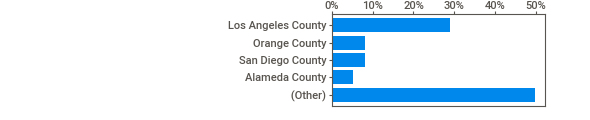
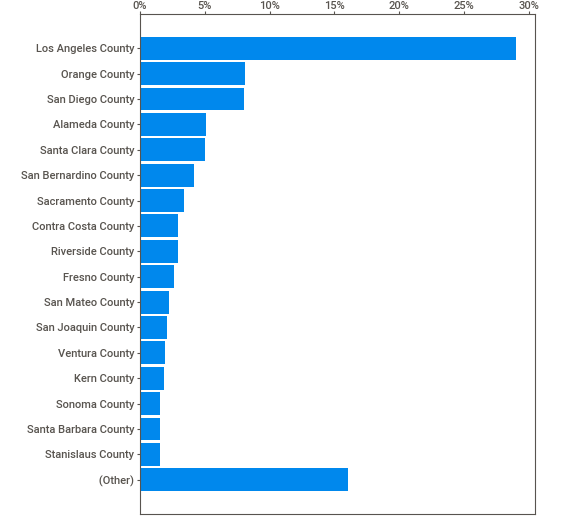
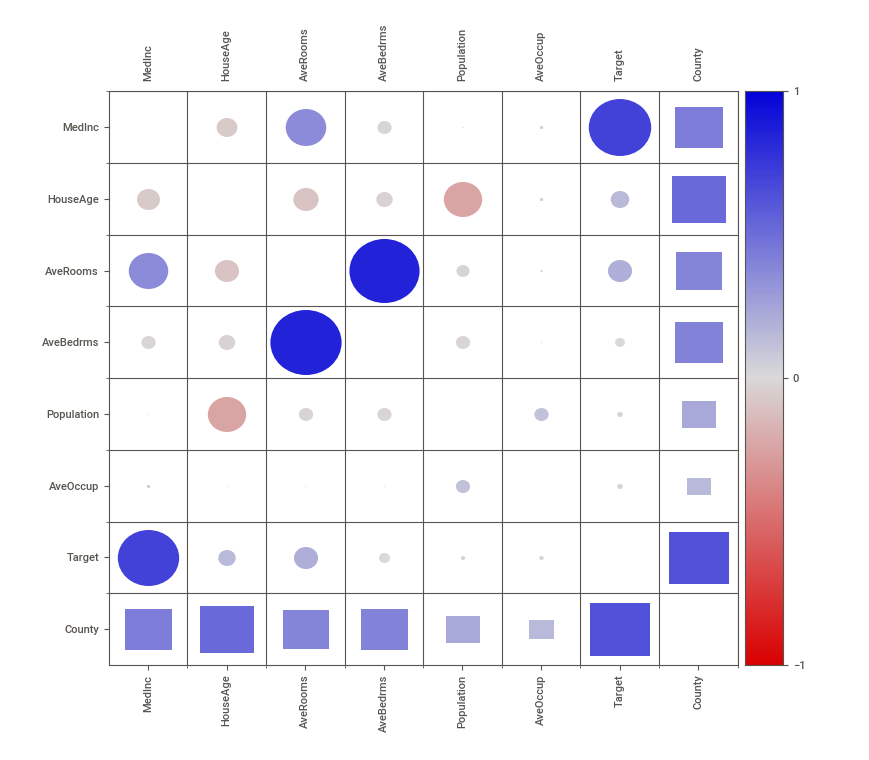
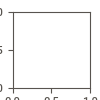

In [26]:
### Now we can check again with SweetViz and see if there is more correlation with the county/road and the target price

analysis = sv.analyze(df)
analysis.show_notebook()

In [27]:
### Finally! We can see a nice correlation between the county and the house's price. This data will be
### more meaningfull than the previous latitude and longitude

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Target      20640 non-null  float64
 7   County      20065 non-null  object 
 8   Road        19541 non-null  object 
dtypes: float64(7), object(2)
memory usage: 1.4+ MB
None


In [28]:
### We are going to use a linear classifier (SGDClassifier) to fulfill the missing roads and counties

missing_roads_idx = []
missing_counties_idx = []

for idx in range(df.shape[0]):
    if df['County'][idx] is None:
        ### All the missing counties' indexes will be stored here to separate them from the already fulfilled counties
        missing_counties_idx.append(idx)
    if df['Road'][idx] is None:
        ### All the missing roads' indexes will be stored here to separate them from the already fulfilled roads
        missing_roads_idx.append(idx)

### Example where road or county is None

print(df.iloc[missing_roads_idx[0]])
print(df.iloc[missing_counties_idx[0]])

MedInc                3.6875
HouseAge                  42
AveRooms             5.70787
AveBedrms           0.973783
Population               651
AveOccup              2.4382
Target                 1.573
County        Alameda County
Road                    None
Name: 284, dtype: object
MedInc         3.6728
HouseAge           25
AveRooms       2.6712
AveBedrms     1.23583
Population        592
AveOccup       1.3424
Target        5.00001
County           None
Road           A Dock
Name: 15614, dtype: object


In [29]:
### Now, based on the correlations, the one that were more correlated were: MedInc, HouseAge, AveBedrms and AveRooms

roads_X_train = np.array([[df['MedInc'][idx], df['HouseAge'][idx], df['AveBedrms'][idx], df['AveRooms'][idx]] 
                          for idx in range(df.shape[0]) if idx not in missing_roads_idx])
roads_y_train = np.array([df['Road'][idx] 
                          for idx in range(df.shape[0]) if idx not in missing_roads_idx])
roads_X_test = np.array([[df['MedInc'][idx], df['HouseAge'][idx], df['AveBedrms'][idx], df['AveRooms'][idx]] 
                          for idx in range(df.shape[0]) if idx in missing_roads_idx])

counties_X_train = np.array([[df['MedInc'][idx], df['HouseAge'][idx], df['AveBedrms'][idx], df['AveRooms'][idx]] 
                          for idx in range(df.shape[0]) if idx not in missing_counties_idx])
counties_y_train = np.array([df['County'][idx] 
                          for idx in range(df.shape[0]) if idx not in missing_counties_idx])
counties_X_test = np.array([[df['MedInc'][idx], df['HouseAge'][idx], df['AveBedrms'][idx], df['AveRooms'][idx]] 
                          for idx in range(df.shape[0]) if idx in missing_counties_idx])

In [30]:
roads_X_train[:5]

array([[ 8.3252    , 41.        ,  1.02380952,  6.98412698],
       [ 8.3014    , 21.        ,  0.97188049,  6.23813708],
       [ 7.2574    , 52.        ,  1.07344633,  8.28813559],
       [ 5.6431    , 52.        ,  1.07305936,  5.8173516 ],
       [ 3.8462    , 52.        ,  1.08108108,  6.28185328]])

In [31]:
from sklearn.linear_model import SGDClassifier

road_classifier = SGDClassifier()
county_classifier = SGDClassifier()

In [32]:
road_classifier.fit(roads_X_train, roads_y_train)
county_classifier.fit(counties_X_train, counties_y_train)

roads_predicted = road_classifier.predict(roads_X_test)
counties_predicted = county_classifier.predict(counties_X_test)

In [33]:
### These are the roads that the classifier predicted based on those four values that we specified

np.unique(roads_predicted)

array(['35th Street', '9th Street', 'Amanda Drive', 'Atwal Court',
       'Benicia Road', 'Bryant Street', 'Denmark Street',
       'East Lugonia Avenue', 'Fillmore Street', 'Kelsey Street',
       'North Armstrong Avenue', 'Paseo Westpark', 'San Diego Freeway',
       'Sherland Avenue', 'Sincero Drive', 'Slater Avenue',
       'University Avenue', 'Vierra Canyon Road', 'West Sierra Avenue',
       'West Tasman Drive', 'Winston Avenue'], dtype='<U77')

In [34]:
### These are the counties that the classifier predicted based on those four values that we specified

np.unique(counties_predicted)

array(['Los Angeles County', 'Marin County', 'San Diego County'],
      dtype='<U22')

In [35]:
### Now we fulfill the None values with the predicted ones

for n, idx in enumerate(missing_counties_idx):
    df['County'][idx] = counties_predicted[n]

for n, idx in enumerate(missing_roads_idx):
    df['Road'][idx] = roads_predicted[n]

df.info()

### Now all the columns have the same number of non-null values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Target      20640 non-null  float64
 7   County      20640 non-null  object 
 8   Road        20640 non-null  object 
dtypes: float64(7), object(2)
memory usage: 1.4+ MB


In [36]:
### We cannot feed our model with string data, so we have to encode it first with numbers

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['County'] = encoder.fit_transform(df['County'])
df['Road'] = encoder.fit_transform(df['Road'])

In [38]:
### pk.dump(df, open('dataset_processed.pickle', 'wb'))
df = pk.load(open('data/dataset_processed.pickle', 'rb'))

### Randomize the rows because near by houses were contiguous in the DataFrame and could lead us to overfitting
### frac = 1 to get the whole dataset and not just one row

df = df.sample(axis = 0, frac = 1)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Target,County,Road
16882,3.0744,31.0,3.873096,1.071066,1581.0,2.006345,4.577,42,1812
3647,2.7714,8.0,3.753957,1.130935,1803.0,2.594245,1.857,20,8052
10229,2.6563,36.0,3.072607,0.920792,778.0,2.567657,1.550,32,8808
17191,3.3047,52.0,7.936364,1.431818,941.0,4.277273,2.861,42,1190
1444,4.4536,23.0,5.746867,1.030075,969.0,2.428571,1.840,6,3490


### ***Training our model***

In [39]:
y = df.iloc[:, -3] ### Get all the targets

#df.drop(labels = ['Target'], axis = 1, inplace = True)
df.head()

X = df.values
X = [x[1:] for x in X]

### We drop the media income column to test our model and see the results

In [40]:
### Split our training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [44]:
### For this kind of problem one of the best approaches is to use a RandomForestRegressor
### This will reduce overfitting and improve accuracy by running the same features through different
### trees, and finally the output will be chosen by votes. The one that was more times predicted by all
### the trees is the one chosen

from sklearn.ensemble import RandomForestRegressor

### model = pk.load(open('data/model_price_house.pickle', 'rb'))

model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
### pk.dump(model, open('model_price_house.pickle', 'wb'))
y_pred = model.predict(X_test)

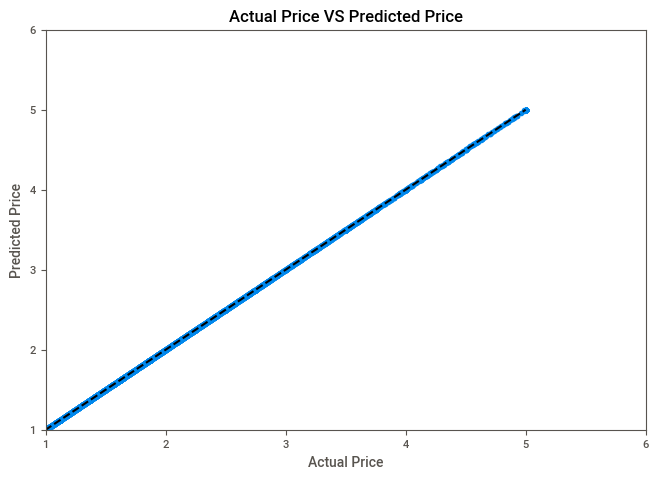

In [46]:
### Now we compare the predictions to the actual target

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(y_pred, y_test)
ax.set_xlim([1, 6])
ax.set_ylim([1, 6])
ax.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 1.5)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Actual Price VS Predicted Price')
plt.show()

### The black line should be the desired ouput, and the blue dots are the actual predictions.
### We can say that is a very accurate output!

In [54]:
from sklearn.metrics import r2_score

print('The R2 score between y_test and y_pred is {0}'.format(r2_score(y_test, y_pred)))

print('The first 5 values inside the test targets: ', end = '')
print(*y_test[:5], sep = ', ')
print('The first 5 values inside the prediction targets: ', end = '')
print(*y_pred[:5], sep = ', ')

The R2 score between y_test and y_pred is 0.9999995990743472
The first 5 values inside the test targets: 0.939, 2.098, 4.837, 1.347, 1.222
The first 5 values inside the prediction targets: 0.9390899999999982, 2.0980100000000035, 4.836590000000005, 1.3470199999999979, 1.222109999999999


In [57]:
errors = abs(y_pred - y_test)
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: {0}%'.format(round(accuracy, 2)))

Accuracy: 99.98%


In [69]:
### Now let's make our own prediction

house = np.array([[4.54, 17.0, 6.493421, 0.934211, 463.0, 3.046053, 39, 1290]])
house2 = np.array([[10.2, 15.0, 7.2, 1.12, 463.0, 3.046053, 39, 1290]])

price = model.predict(house)
price2 = model.predict(house2)

In [70]:
print('Price of the first house is {0}$'.format(price[0] * 100000))
print('Price of the second house is {0}$'.format(price2[0] * 100000))

### It's pretty interesting this result. At the beginning we had a pretty strong correlation
### between the price of the house and the average income of the family, but now we predicted two houses in the same
### road and county, one is 2 years older, with more rooms and bedrooms and we just dropped the income 
### Even though it has no information about the income the output price is pretty much the same. 
### So, finally we can conclude that the most important feature of a house is the location! 

Price of the first house is 304643.00000000006$
Price of the second house is 304643.00000000006$


In [ ]:
### Here is the model taking into account the average income as well

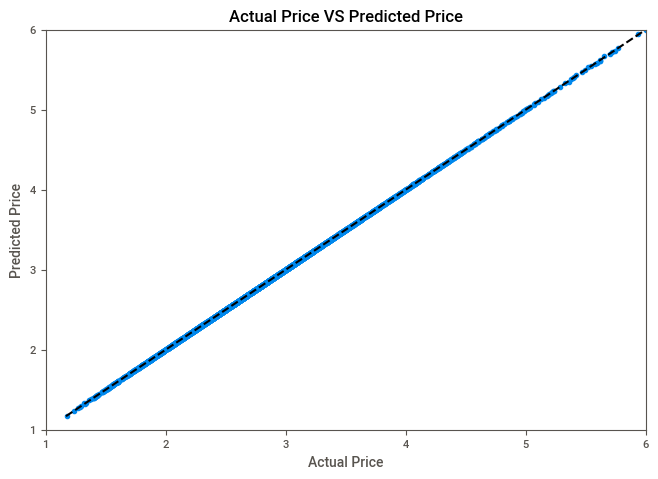

In [ ]:
X = df.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model2 = RandomForestRegressor()

model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(y_pred, y_test)
ax.set_xlim([1, 6])
ax.set_ylim([1, 6])
ax.plot([y_test.min(),y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 1.5)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Actual Price VS Predicted Price')
plt.show()

In [ ]:
house = np.array([[4.54, 17.0, 6.493421, 0.934211, 463.0, 3.046053, 39, 1290]])
house2 = np.array([[10.2, 15.0, 7.2, 1.12, 463.0, 3.046053, 39, 1290]])

price = model2.predict(house)
price2 = model2.predict(house2)

print('Price of the first house is {0}$'.format(price[0] * 100000))
print('Price of the second house is {0}$'.format(price2[0] * 100000))

### Pretty much the same result, but now with twice the income among each other.
### Proving that the income was not correlated at the end

Price of the first house is 304622.06682154763$
Price of the second house is 304621.36353433924$
